In [ ]:
# !pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --------- ------------------------------ 2.4/9.8 MB 12.2 MB/s eta 0:00:01
   ------------------- -------------------- 4.7/9.8 MB 11.9 MB/s eta 0:00:01
   ----------------------------- ---------- 7.3/9.8 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 10.7 MB/s eta 0:00:00


In [86]:
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
# matplotlib 한글 사용

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 1. 데이터 불러와서 가공하기

데이터 불러오기

In [3]:
bus_df = pd.read_csv("../Mook/transportation_bus.csv")
train_df = pd.read_csv("../Mook/transportation_train.csv")
weather_df = pd.read_csv('data/all_weather.csv')

# 각 데이터 프레임의 컬럼 조회
bus_df.columns, train_df.columns, weather_df.columns

(Index(['date', 'total_passenger', 'commute_passenger', 'other_passenger',
        'holiday_or_weekend'],
       dtype='object'),
 Index(['date', 'total_passenger', 'commute_passenger', 'other_passenger',
        'holiday_or_weekend'],
       dtype='object'),
 Index(['Unnamed: 0', 'date', 'fine_dust(㎍/㎥)', 'avg_temp', 'min_temp',
        'max_temp', 'precipitation(mm)', 'snow_depth(mm)', 'day_type', 'season',
        'year', 'fd_grade', 'p_grade', 's_grade', 'at_grade'],
       dtype='object'))

### 1-1. 분석에 용이하게 데이터프레임 가공하기

1-1-1. 버스 데이터

In [4]:
# 필요 컬럼을 추출
bus_df = bus_df[['date', 'total_passenger', 'commute_passenger', 'other_passenger']]

In [5]:
# 적절한 컬럼명 지정
bus_df.columns = ['date', 'bus_total_passenger', 'bus_commute_passenger', 'bus_other_passenger']

# 변경 확인
bus_df.head(1)

date  bus_total_passenger  bus_commute_passenger  bus_other_passenger
0  2022-01-01            1858954.0               519623.0            1339331.0

1-1-2. 지하철 데이터

In [6]:
# 필요 컬럼을 추출
train_df = train_df[['date', 'total_passenger', 'commute_passenger', 'other_passenger']]

In [7]:
# 적절한 컬럼명 지정
train_df.columns = ['date', 'train_total_passenger', 'train_commute_passenger', 'train_other_passenger']

# 변경 확인
train_df.head(1)

date  train_total_passenger  train_commute_passenger  \
0  2022-01-01              1792725.0                 502533.0   

   train_other_passenger  
0              1290192.0

1-1-3. 날씨 데이터

In [8]:
# 필요 컬럼을 추출
weather_df = weather_df[['date', 'fine_dust(㎍/㎥)', 'avg_temp', 'min_temp', 'max_temp', 
                         'precipitation(mm)',  'snow_depth(mm)', 'season', 'year', 
                         'fd_grade', 'p_grade', 's_grade', 'at_grade', 'day_type']]

# 변경 확인
weather_df.columns

Index(['date', 'fine_dust(㎍/㎥)', 'avg_temp', 'min_temp', 'max_temp',
       'precipitation(mm)', 'snow_depth(mm)', 'season', 'year', 'fd_grade',
       'p_grade', 's_grade', 'at_grade', 'day_type'],
      dtype='object')

1-1-4. 데이터프레임 합치기

In [9]:
# merge는 두개의 데이터프레임만 결합가능
# 대중교통끼리 결합
merged_transport = pd.merge(bus_df, train_df, how='outer', on='date')

# 결합된 대중교통 데이터프레임과 날씨 데이터프레임 결합
merged_df = pd.merge(merged_transport, weather_df, how='outer', on='date')

# 결합 확인
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1399 non-null   object 
 1   bus_total_passenger      1019 non-null   float64
 2   bus_commute_passenger    1019 non-null   float64
 3   bus_other_passenger      1019 non-null   float64
 4   train_total_passenger    1020 non-null   float64
 5   train_commute_passenger  1020 non-null   float64
 6   train_other_passenger    1020 non-null   float64
 7   fine_dust(㎍/㎥)           1399 non-null   float64
 8   avg_temp                 1399 non-null   float64
 9   min_temp                 1399 non-null   float64
 10  max_temp                 1399 non-null   float64
 11  precipitation(mm)        1399 non-null   float64
 12  snow_depth(mm)           1399 non-null   float64
 13  season                   1399 non-null   object 
 14  year                    

### 1-2. 결측치 처리하기

1-2-1. 결측치 확인하기

In [10]:
# 각 컬럼별 결측치 개수 확인
merged_df.isnull().sum()

date                         0
bus_total_passenger        380
bus_commute_passenger      380
bus_other_passenger        380
train_total_passenger      379
train_commute_passenger    379
train_other_passenger      379
fine_dust(㎍/㎥)               0
avg_temp                     0
min_temp                     0
max_temp                     0
precipitation(mm)            0
snow_depth(mm)               0
season                       0
year                         0
fd_grade                     0
p_grade                      0
s_grade                      0
at_grade                     0
day_type                     0
dtype: int64

1-2-2. 결측치 처리하기

In [11]:
# 결측치가 있는 모든 행을 지움
merged_df = merged_df.dropna()

In [12]:
# 결측치 및 정보 확인
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 365 to 1398
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1016 non-null   object 
 1   bus_total_passenger      1016 non-null   float64
 2   bus_commute_passenger    1016 non-null   float64
 3   bus_other_passenger      1016 non-null   float64
 4   train_total_passenger    1016 non-null   float64
 5   train_commute_passenger  1016 non-null   float64
 6   train_other_passenger    1016 non-null   float64
 7   fine_dust(㎍/㎥)           1016 non-null   float64
 8   avg_temp                 1016 non-null   float64
 9   min_temp                 1016 non-null   float64
 10  max_temp                 1016 non-null   float64
 11  precipitation(mm)        1016 non-null   float64
 12  snow_depth(mm)           1016 non-null   float64
 13  season                   1016 non-null   object 
 14  year                     10

1-2-3. 순서가 있는 범주화 하기

In [13]:
# 범주화 - 계절/미세먼지등급/강수량등급/적설량등급
# 순서있는 범주형 : ordered = True, 순서 없는 범주형 : ordered = False

# 계절
c_season = ["Spring", "Summer", "Fall", "Winter"]
c_season1 = CategoricalDtype(categories = c_season, ordered = True)

# 미세먼지
c_fd_grade = ['Good', 'Normal', 'Bad', 'Very_bad']
c_fd_grade1 = CategoricalDtype(categories = c_fd_grade, ordered = True)

# 강수량
c_p_grade = ['Dry', 'Light', 'Moderate', 'Heavy']
c_p_grade1 = CategoricalDtype(categories = c_p_grade, ordered = True)

# 적설량
c_s_grade = ['No_Snow', 'Light_Snow', 'Moderate_Snow', 'Heavy_Snow']
c_s_grade1 = CategoricalDtype(categories = c_s_grade, ordered = True)

# 평균기온
c_at_grade = ['Very_Cold', 'Cold', 'Mild', 'Warm', 'Hot']
c_at_grade1 = CategoricalDtype(categories = c_at_grade, ordered = True)

# 평일여부
c_day_grade = ['Weekday', 'Weekend']
c_day_grade1 = CategoricalDtype(categories = c_day_grade, ordered = True)

# 적용하기
merged_df["season"] = merged_df["season"].astype(c_season1)
merged_df["fd_grade"] = merged_df["fd_grade"].astype(c_fd_grade1)
merged_df["p_grade"] = merged_df["p_grade"].astype(c_p_grade1)
merged_df["s_grade"] = merged_df["s_grade"].astype(c_s_grade1)
merged_df["at_grade"] = merged_df["at_grade"].astype(c_at_grade1)
merged_df["day_type"] = merged_df["day_type"].astype(c_day_grade1)

# 확인하기
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 365 to 1398
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   date                     1016 non-null   object  
 1   bus_total_passenger      1016 non-null   float64 
 2   bus_commute_passenger    1016 non-null   float64 
 3   bus_other_passenger      1016 non-null   float64 
 4   train_total_passenger    1016 non-null   float64 
 5   train_commute_passenger  1016 non-null   float64 
 6   train_other_passenger    1016 non-null   float64 
 7   fine_dust(㎍/㎥)           1016 non-null   float64 
 8   avg_temp                 1016 non-null   float64 
 9   min_temp                 1016 non-null   float64 
 10  max_temp                 1016 non-null   float64 
 11  precipitation(mm)        1016 non-null   float64 
 12  snow_depth(mm)           1016 non-null   float64 
 13  season                   1016 non-null   category
 14  year       

### 1-3. 기타 전처리

1-3-1. date컬럼의 자료형 변환

In [14]:
# date 컬럼의 자료형을 datetime으로 변환
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 확인
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 365 to 1398
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1016 non-null   datetime64[ns]
 1   bus_total_passenger      1016 non-null   float64       
 2   bus_commute_passenger    1016 non-null   float64       
 3   bus_other_passenger      1016 non-null   float64       
 4   train_total_passenger    1016 non-null   float64       
 5   train_commute_passenger  1016 non-null   float64       
 6   train_other_passenger    1016 non-null   float64       
 7   fine_dust(㎍/㎥)           1016 non-null   float64       
 8   avg_temp                 1016 non-null   float64       
 9   min_temp                 1016 non-null   float64       
 10  max_temp                 1016 non-null   float64       
 11  precipitation(mm)        1016 non-null   float64       
 12  snow_depth(mm)           1016 non-nul

# 데이터 분석 및 시각화

### 2-1. 단일 그룹 분석 - 연도별, 계절별, 평일/주말별

2-1-1. 분석을 위한 함수 정의

In [15]:
# 단일 그룹 분석을 위한 함수 지정

def group_analysis_by_single_column(df, group_col_name, col_name):
    # 그룹화
    grouped_df = df.groupby(group_col_name, observed=True)

    # 그룹별 최대/최소/평균/분산/빈도 계산
    stats = grouped_df[col_name].agg([
        ("Max", "max"),
        ("Min", "min"),
        ("Mean", "mean"),
        ("Median", "median"),
        ("Variance", "var"),
        ("Count", "count")
    ])
    return stats

2-1-2. 시각화를 위한 함수 정의

In [16]:
# 단일 그룹 시각화를 위한 함수 지정

# 통계치 시각화 함수 정의
def plot_statistics(stats_df, group_name):
    # Plot 설정
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle(f'{group_name}별 통계치')
    
    # Plot 1: Mean (평균)
    sns.lineplot(data=stats_df, x=stats_df.index, y="Mean", ax=axes[0, 0])
    axes[0, 0].set_title("Mean (평균)")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Median (중앙값)
    sns.barplot(data=stats_df, x=stats_df.index, y="Median", ax=axes[0, 1])
    axes[0, 1].set_title("Median (중앙값)")
    axes[0, 1].set_ylabel("Median")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Variance (분산)
    sns.barplot(data=stats_df, x=stats_df.index, y="Variance", ax=axes[0, 2])
    axes[0, 2].set_title("Variance (분산)")
    axes[0, 2].set_ylabel("Variance")
    axes[0, 2].tick_params(axis='x', rotation=45)

    # Plot 4: Count (빈도)
    sns.barplot(data=stats_df, x=stats_df.index, y="Count", ax=axes[1, 0])
    axes[1, 0].set_title("Count (빈도)")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Plot 5: Max and Min (최대 및 최소)
    stats_df[["Max", "Min"]].plot(kind='line', ax=axes[1, 1], marker='o')
    axes[1, 1].set_title("Max & Min (최대 & 최소)")
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)

    # 빈 그래프 (Plot 6) - 필요에 따라 추가할 수도 있음
    axes[1, 2].axis('off')  # 마지막 그래프는 비워둠
    
    # 레이아웃 조정
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 제목과 간격 조절
    plt.show()

2-1-3. 버스(전체) - 분석

In [17]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 버스 - 전체
btdf_year_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "year", 
                    col_name = "bus_total_passenger")
btdf_season_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "season", 
                    col_name = "bus_total_passenger")
btdf_day_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "day_type", 
                    col_name = "bus_total_passenger")

# 딕셔너리로 데이터프레입 합치기
combined_stats_bt1 = {
    "year": btdf_year_stats,
    "season": btdf_season_stats,
    "day_type": btdf_day_stats
}

print( "단일 그룹 분석 - 버스 - 전체")
# 결과 확인
for key, value in combined_stats_bt1.items():
    print(f"\n\n{key} Stats: (버스 - 전체)\n", value)

단일 그룹 분석 - 버스 - 전체


year Stats: (버스 - 전체)
             Max        Min          Mean     Median      Variance  Count
year                                                                    
2022  5170794.0  1400020.0  4.036126e+06  4387615.0  8.473381e+11    357
2023  5063317.0  1523468.0  4.162471e+06  4605035.0  8.016165e+11    363
2024  5338460.0  1579526.0  4.269315e+06  4712012.0  7.955850e+11    296


season Stats: (버스 - 전체)
               Max        Min          Mean     Median      Variance  Count
season                                                                    
Spring  5110526.0  1859371.0  4.193470e+06  4687175.0  7.586816e+11    269
Summer  5235636.0  2304063.0  4.263667e+06  4685707.5  6.905252e+11    272
Fall    5338460.0  1725294.0  4.253216e+06  4759433.0  9.002177e+11    239
Winter  5156498.0  1400020.0  3.861488e+06  4271484.0  8.702584e+11    236


day_type Stats: (버스 - 전체)
                 Max        Min          Mean     Median      Variance  Count
day_type

2-1-4. 버스(전체) - 시각화

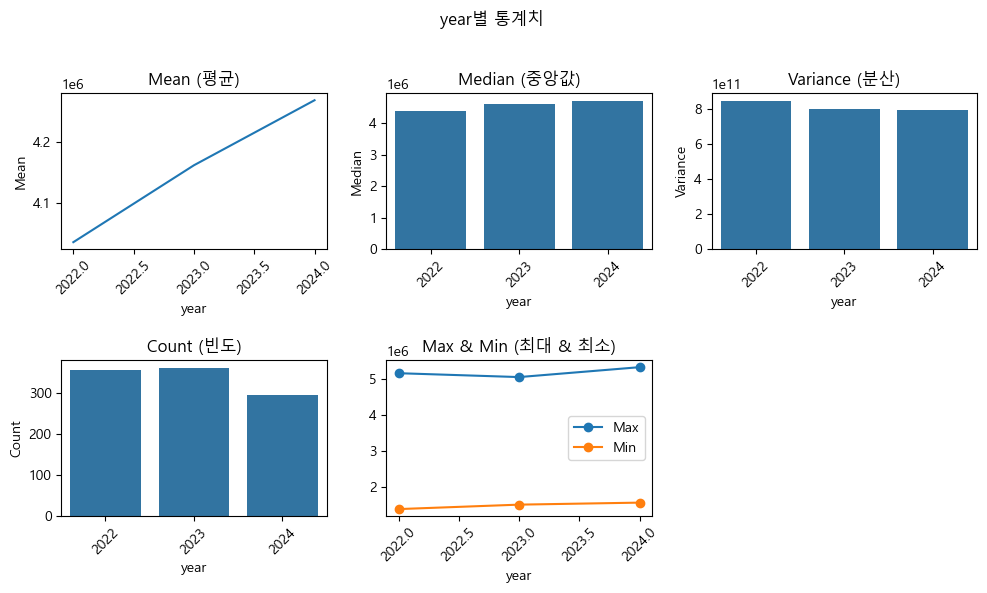

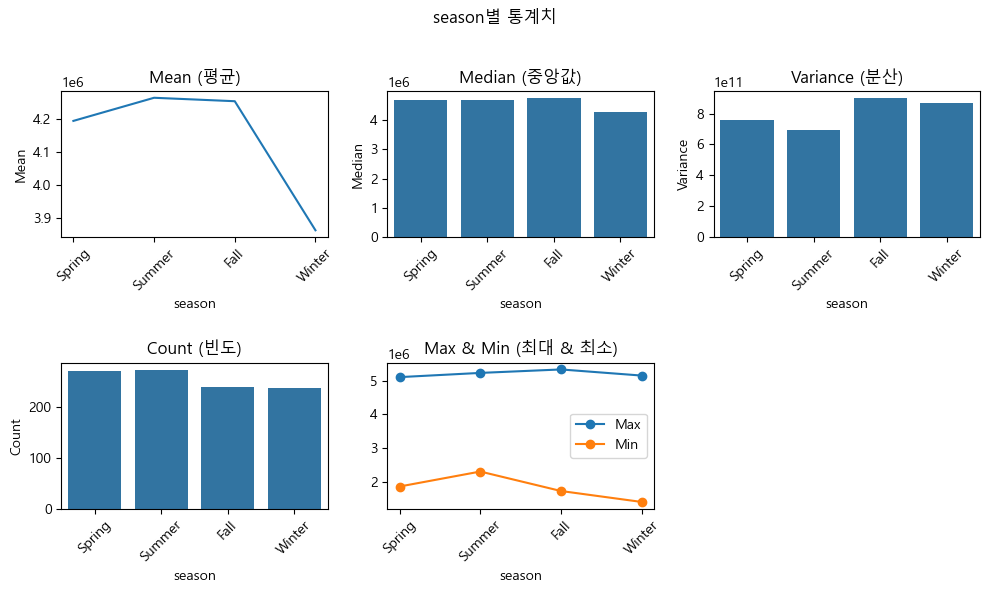

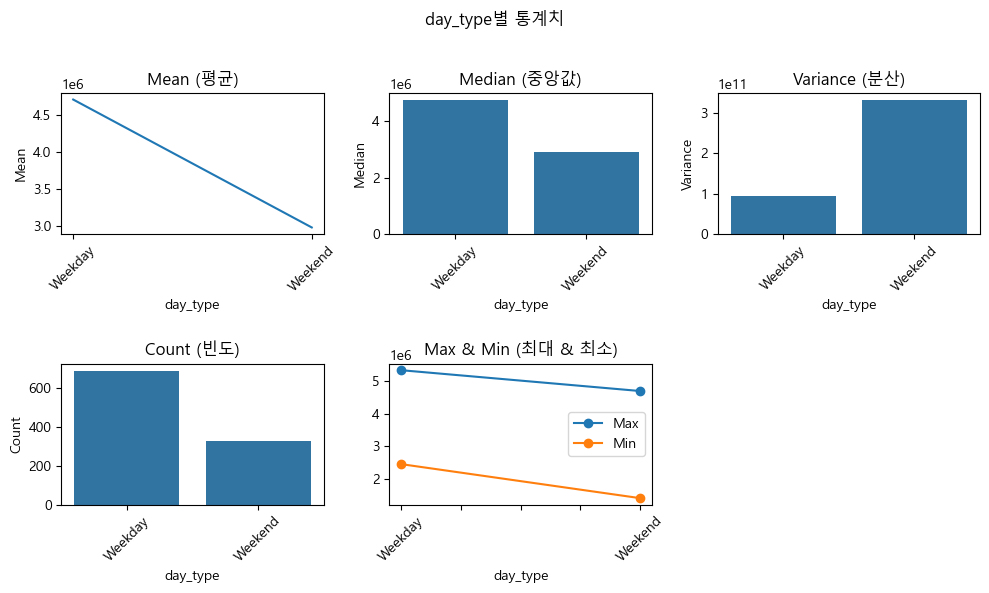

In [18]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_bt1.items():
    plot_statistics(stats_df, key)

2-1-5. 버스(통근자) - 분석

In [19]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 버스 - 통근자
bcdf_year_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "year", 
                    col_name = "bus_commute_passenger")
bcdf_season_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "season", 
                    col_name = "bus_commute_passenger")
bcdf_day_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "day_type", 
                    col_name = "bus_commute_passenger")

# 딕셔너리로 데이터프레입 합치기
combined_stats_bc1 = {
    "year": bcdf_year_stats,
    "season": bcdf_season_stats,
    "day_type": bcdf_day_stats
}

print( "단일 그룹 분석 - 버스 - 통근자")
# 결과 확인
for key, value in combined_stats_bc1.items():
    print(f"\n\n{key} Stats: (버스 - 통근자)\n", value)

단일 그룹 분석 - 버스 - 통근자


year Stats: (버스 - 통근자)
             Max       Min          Mean     Median      Variance  Count
year                                                                   
2022  2187229.0  409493.0  1.599351e+06  1848867.0  2.993464e+11    357
2023  2140038.0  453036.0  1.637569e+06  1958647.0  2.926354e+11    363
2024  2258019.0  470735.0  1.657425e+06  1975652.5  2.876817e+11    296


season Stats: (버스 - 통근자)
               Max       Min          Mean     Median      Variance  Count
season                                                                   
Spring  2129665.0  543249.0  1.654320e+06  2012620.0  2.871464e+11    269
Summer  2177050.0  691292.0  1.682169e+06  2003298.0  2.641997e+11    272
Fall    2258019.0  515131.0  1.659445e+06  2014181.0  3.207223e+11    239
Winter  2187229.0  409493.0  1.512009e+06  1824871.5  2.922074e+11    236


day_type Stats: (버스 - 통근자)
                 Max       Min          Mean     Median      Variance  Count
day_type        

2-1-6. 버스(통근자) - 시각화

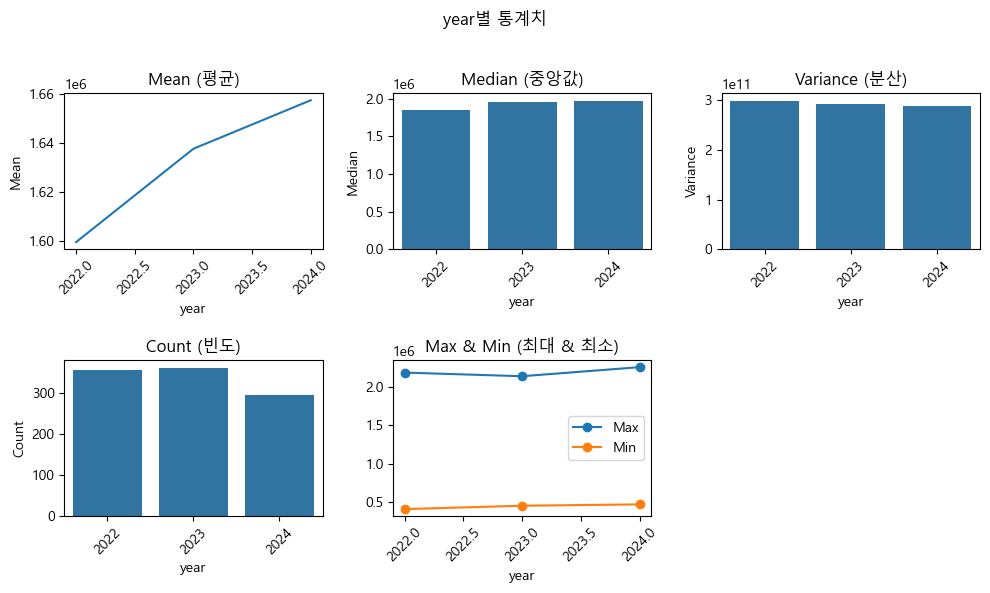

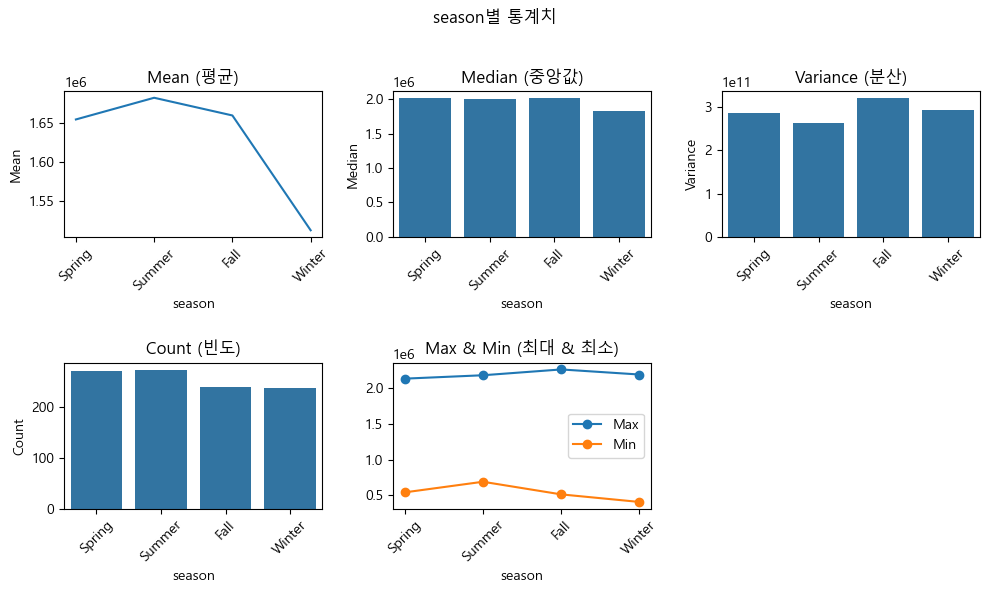

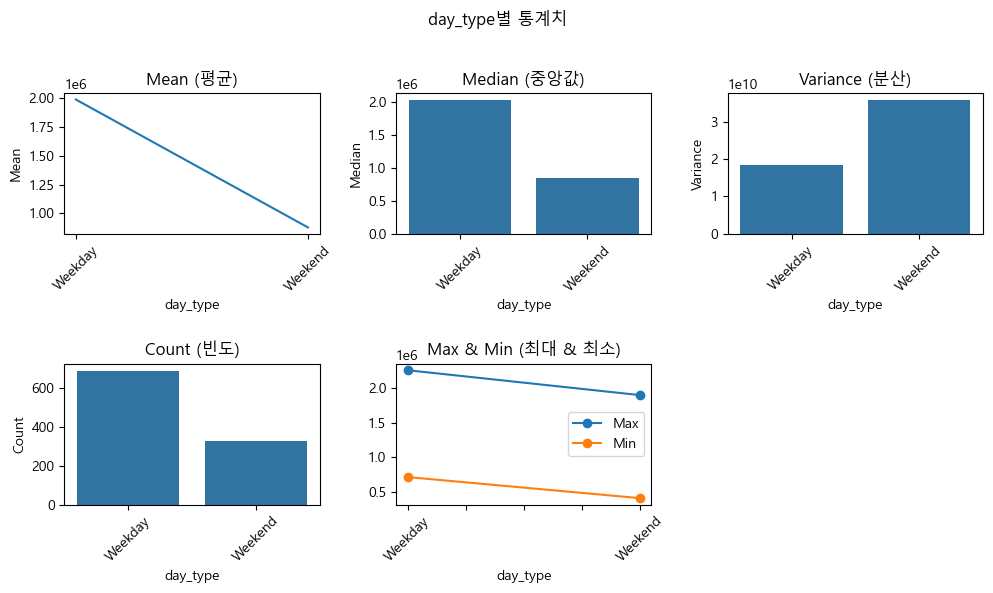

In [20]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_bc1.items():
    plot_statistics(stats_df, key)

2-1-7. 버스(비통근자) - 분석

In [21]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 버스 - 비통근자
bcdf_year_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "year", 
                    col_name = "bus_commute_passenger")
bcdf_season_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "season", 
                    col_name = "bus_commute_passenger")
bcdf_day_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "day_type", 
                    col_name = "bus_commute_passenger")

# 딕셔너리로 데이터프레입 합치기
combined_stats_bc1 = {
    "year": bcdf_year_stats,
    "season": bcdf_season_stats,
    "day_type": bcdf_day_stats
}

print( "단일 그룹 분석 - 버스 - 비통근자")
# 결과 확인
for key, value in combined_stats_bc1.items():
    print(f"\n\n{key} Stats: (버스 - 비통근자)\n", value)

단일 그룹 분석 - 버스 - 비통근자


year Stats: (버스 - 비통근자)
             Max       Min          Mean     Median      Variance  Count
year                                                                   
2022  2187229.0  409493.0  1.599351e+06  1848867.0  2.993464e+11    357
2023  2140038.0  453036.0  1.637569e+06  1958647.0  2.926354e+11    363
2024  2258019.0  470735.0  1.657425e+06  1975652.5  2.876817e+11    296


season Stats: (버스 - 비통근자)
               Max       Min          Mean     Median      Variance  Count
season                                                                   
Spring  2129665.0  543249.0  1.654320e+06  2012620.0  2.871464e+11    269
Summer  2177050.0  691292.0  1.682169e+06  2003298.0  2.641997e+11    272
Fall    2258019.0  515131.0  1.659445e+06  2014181.0  3.207223e+11    239
Winter  2187229.0  409493.0  1.512009e+06  1824871.5  2.922074e+11    236


day_type Stats: (버스 - 비통근자)
                 Max       Min          Mean     Median      Variance  Count
day_type    

2-1-8. 버스(비통근자) - 시각화

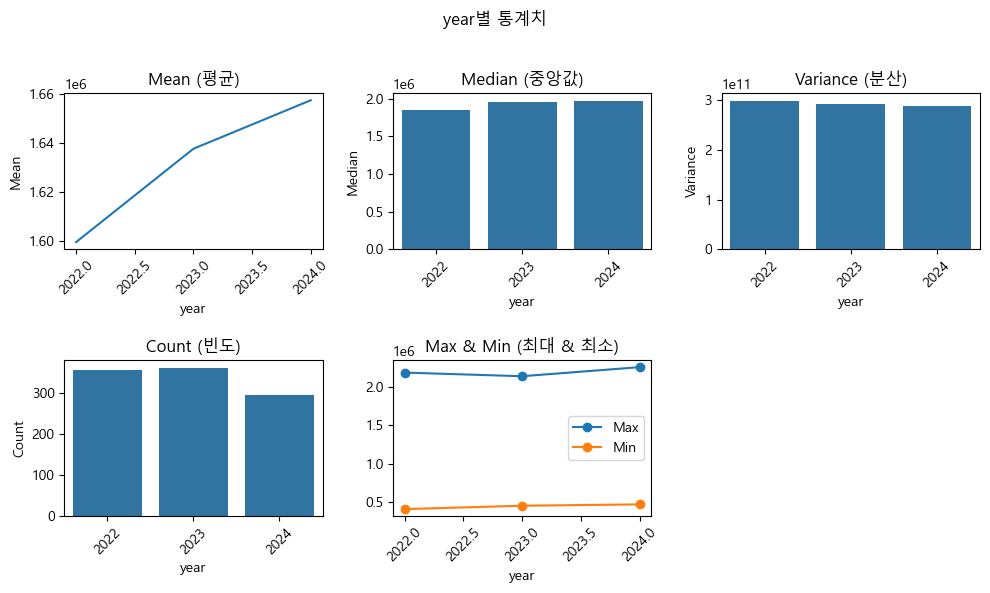

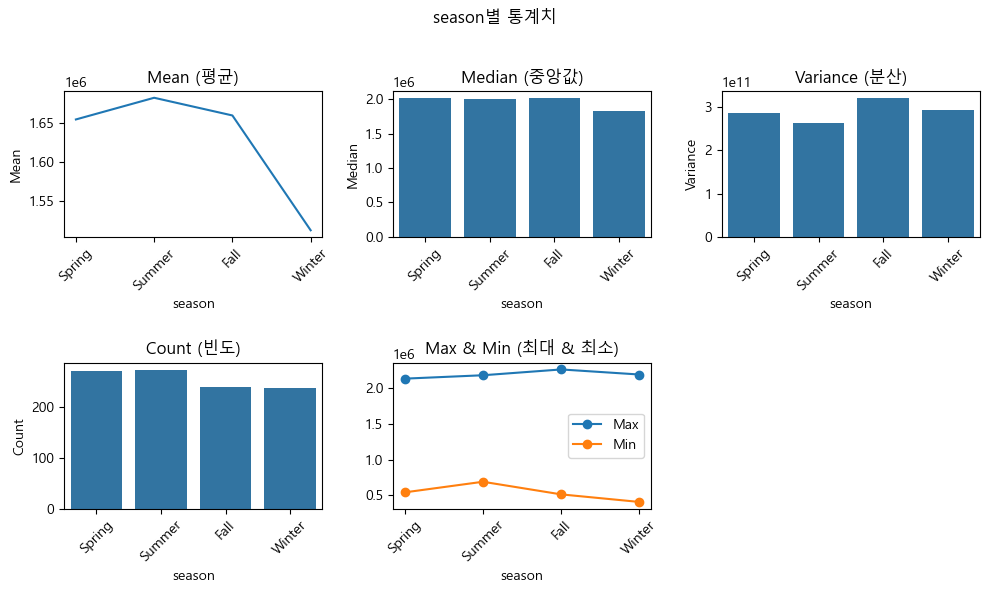

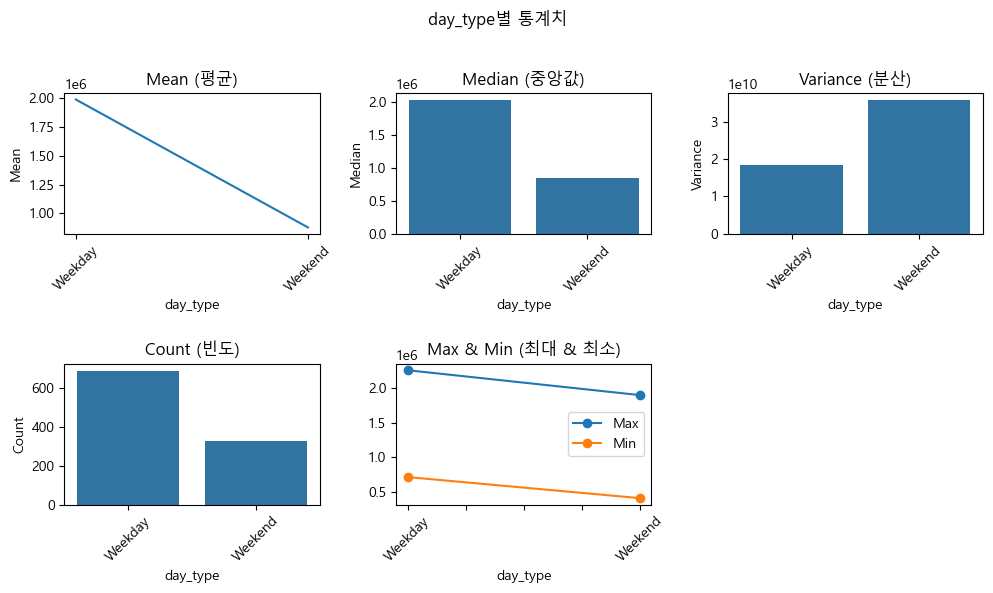

In [22]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_bc1.items():
    plot_statistics(stats_df, key)

2-1-9. 지하철(전체) - 분석

In [23]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 지하철 - 전체
ttdf_year_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "year", 
                    col_name = "train_total_passenger")
ttdf_season_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "season", 
                    col_name = "train_total_passenger")
ttdf_day_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "day_type", 
                    col_name = "train_total_passenger")

# 딕셔너리로 데이터프레입 합치기
combined_stats_tt1 = {
    "year": ttdf_year_stats,
    "season": ttdf_season_stats,
    "day_type": ttdf_day_stats
}

print( "단일 그룹 분석 - 지하철 - 전체")
# 결과 확인
for key, value in combined_stats_tt1.items():
    print(f"\n\n{key} Stats: (지하철 - 전체)\n", value)

단일 그룹 분석 - 지하철 - 전체


year Stats: (지하철 - 전체)
             Max        Min          Mean     Median      Variance  Count
year                                                                    
2022  5838293.0  1241418.0  4.446802e+06  4818474.0  1.204229e+12    357
2023  6102612.0  1563805.0  4.866442e+06  5441437.0  1.255484e+12    363
2024  6232284.0  1723511.0  4.933157e+06  5496752.0  1.287540e+12    296


season Stats: (지하철 - 전체)
               Max        Min          Mean     Median      Variance  Count
season                                                                    
Spring  6232284.0  1885163.0  4.823937e+06  5302464.0  1.268310e+12    269
Summer  5993030.0  2342500.0  4.741233e+06  5183253.0  1.063459e+12    272
Fall    6121264.0  1741406.0  4.861587e+06  5494620.0  1.340452e+12    239
Winter  5903240.0  1241418.0  4.512997e+06  5009101.5  1.471615e+12    236


day_type Stats: (지하철 - 전체)
                 Max        Min          Mean     Median      Variance  Count
day_

2-1-10. 지하철(전체) - 시각화

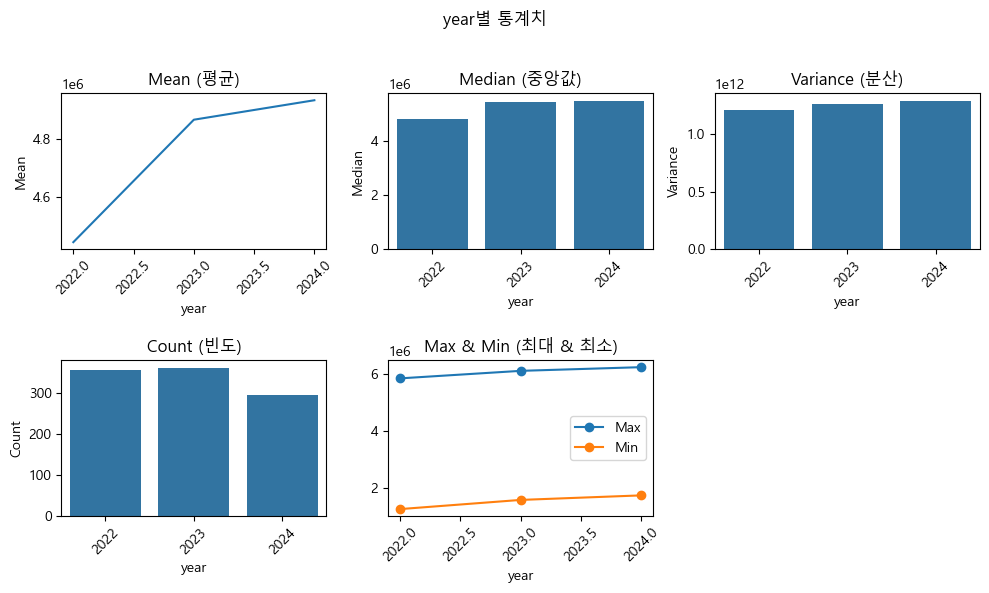

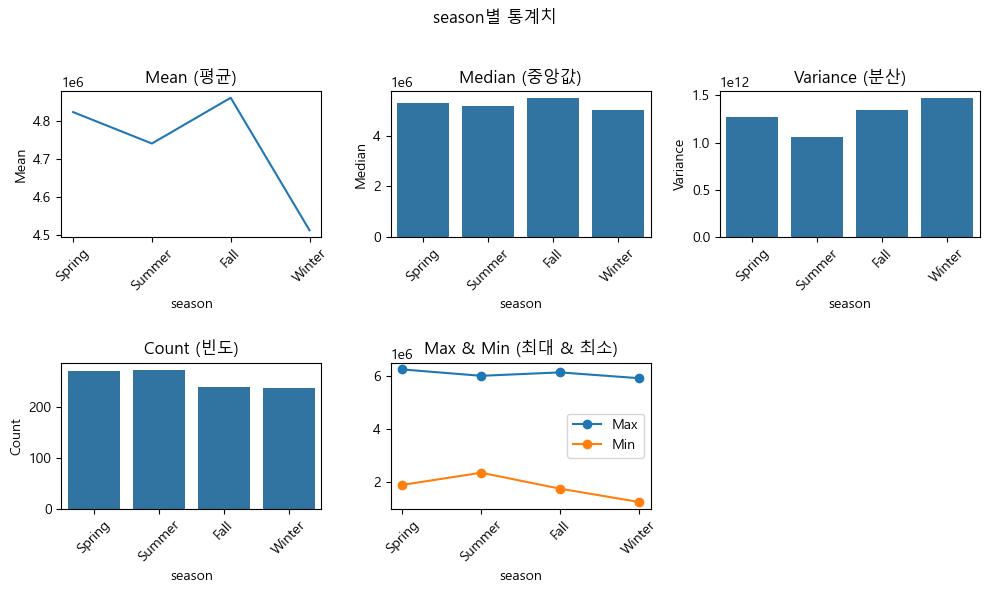

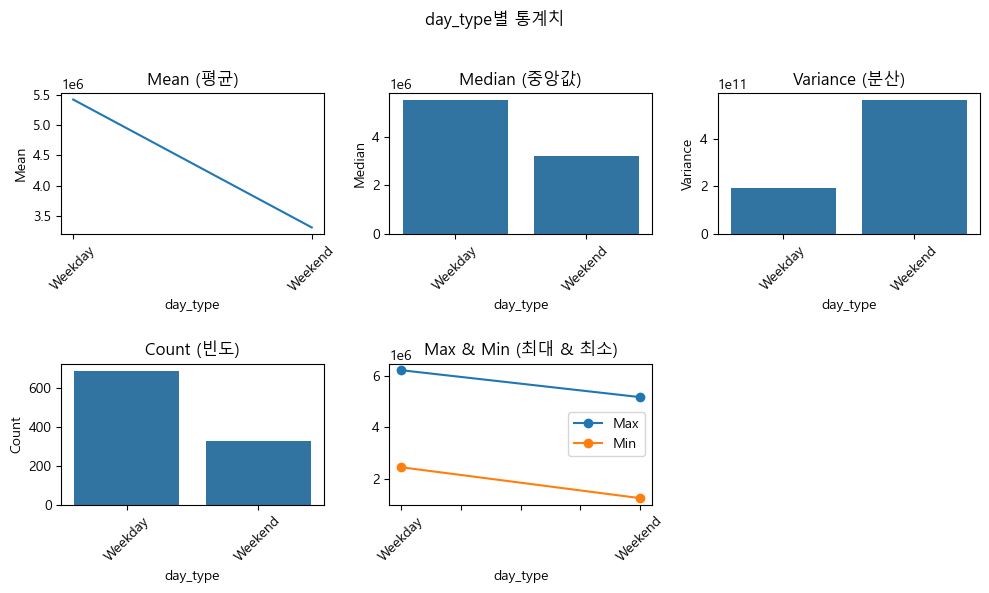

In [24]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_tt1.items():
    plot_statistics(stats_df, key)

2-1-11. 지하철(통근자) - 분석

In [25]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 지하철 - 통근자
tcdf_year_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "year", 
                    col_name = "train_commute_passenger")
tcdf_season_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "season", 
                    col_name = "train_commute_passenger")
tcdf_day_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "day_type", 
                    col_name = "train_commute_passenger")

# 딕셔너리로 데이터프레입 합치기
combined_stats_tc1 = {
    "year": tcdf_year_stats,
    "season": tcdf_season_stats,
    "day_type": tcdf_day_stats
}

print( "단일 그룹 분석 - 지하철 - 통근자")
# 결과 확인
for key, value in combined_stats_tc1.items():
    print(f"\n\n{key} Stats: (지하철 - 통근자)\n", value)

단일 그룹 분석 - 지하철 - 통근자


year Stats: (지하철 - 통근자)
             Max       Min          Mean     Median      Variance  Count
year                                                                   
2022  2639540.0  362195.0  1.921298e+06  2294838.0  5.305825e+11    357
2023  2733565.0  446118.0  2.066965e+06  2533907.0  5.750612e+11    363
2024  2780549.0  491341.0  2.076657e+06  2551239.5  5.831195e+11    296


season Stats: (지하철 - 통근자)
               Max       Min          Mean     Median      Variance  Count
season                                                                   
Spring  2780549.0  553553.0  2.059362e+06  2520894.0  5.673723e+11    269
Summer  2719393.0  719067.0  2.035556e+06  2459226.5  5.038425e+11    272
Fall    2723203.0  506430.0  2.051386e+06  2570218.0  6.042993e+11    239
Winter  2648708.0  362195.0  1.919412e+06  2344723.5  5.905636e+11    236


day_type Stats: (지하철 - 통근자)
                 Max       Min          Mean     Median      Variance  Count
day_type    

2-1-12. 지하철(통근자) - 시각화

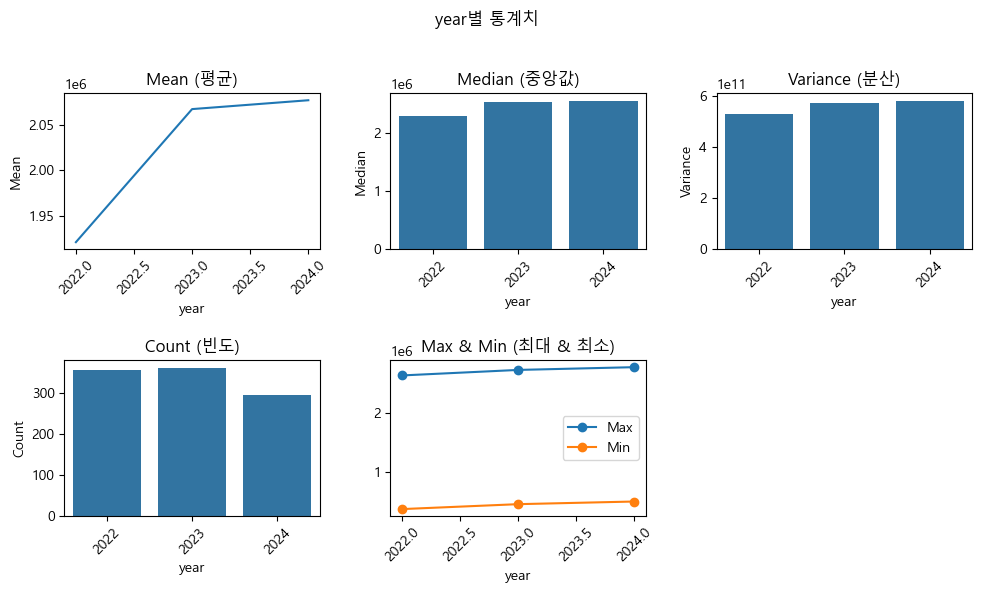

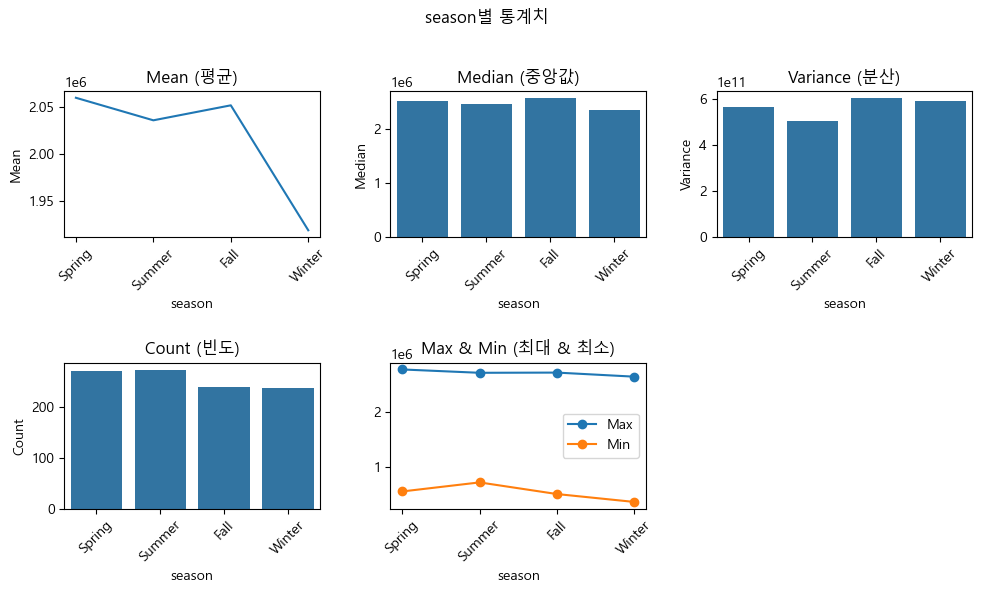

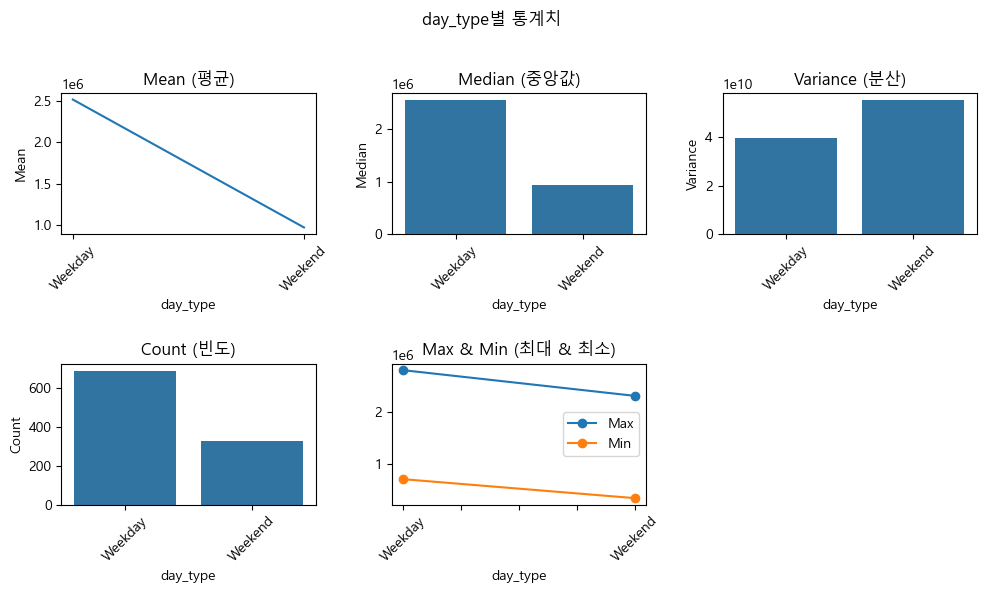

In [26]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_tc1.items():
    plot_statistics(stats_df, key)

2-1-13. 지하철(비통근자) - 분석

In [27]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 지하철 - 비통근자
todf_year_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "year", 
                    col_name = "train_other_passenger")
todf_season_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "season", 
                    col_name = "train_other_passenger")
todf_day_stats = group_analysis_by_single_column(
                    df = merged_df, 
                    group_col_name = "day_type", 
                    col_name = "train_other_passenger")

# 딕셔너리로 데이터프레입 합치기
combined_stats_to1 = {
    "year": todf_year_stats,
    "season": todf_season_stats,
    "day_type": todf_day_stats
}

print( "단일 그룹 분석 - 지하철 - 비통근자")
# 결과 확인
for key, value in combined_stats_to1.items():
    print(f"\n\n{key} Stats: (지하철 - 비통근자)\n", value)

단일 그룹 분석 - 지하철 - 비통근자


year Stats: (지하철 - 비통근자)
             Max        Min          Mean     Median      Variance  Count
year                                                                    
2022  3264191.0   879223.0  2.525504e+06  2633453.0  2.036671e+11    357
2023  3441575.0  1117687.0  2.799476e+06  2931679.0  1.858297e+11    363
2024  3538816.0  1232170.0  2.856500e+06  2984095.0  1.942175e+11    296


season Stats: (지하철 - 비통근자)
               Max        Min          Mean     Median      Variance  Count
season                                                                    
Spring  3538816.0  1331610.0  2.764575e+06  2895985.0  2.121696e+11    269
Summer  3380453.0  1623433.0  2.705677e+06  2771912.0  1.484063e+11    272
Fall    3469738.0  1234976.0  2.810201e+06  2963260.0  2.070416e+11    239
Winter  3441575.0   879223.0  2.593584e+06  2768630.0  2.796639e+11    236


day_type Stats: (지하철 - 비통근자)
                 Max        Min          Mean     Median      Variance  Co

2-1-14. 지하철(비통근자) - 시각화

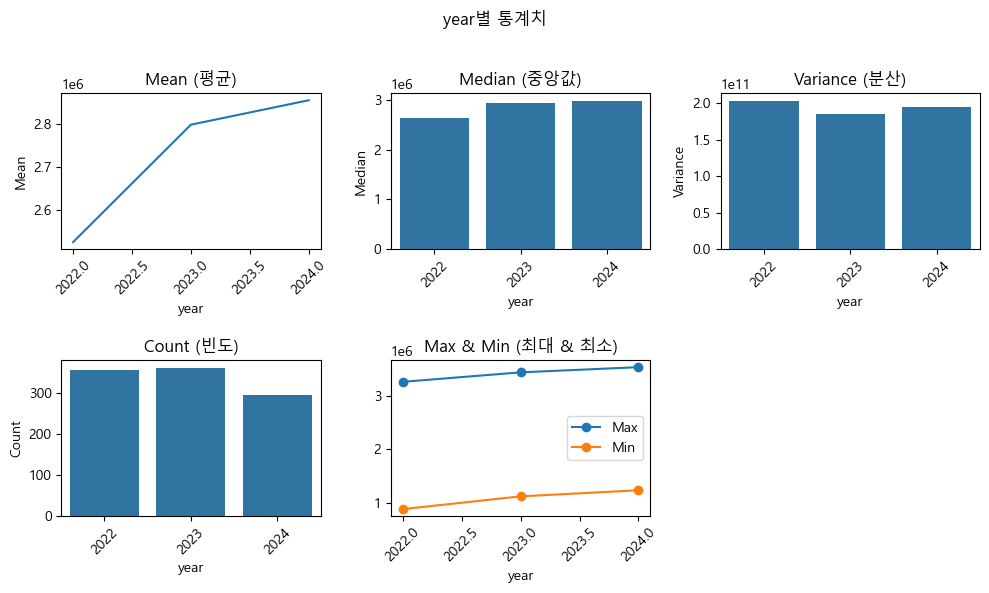

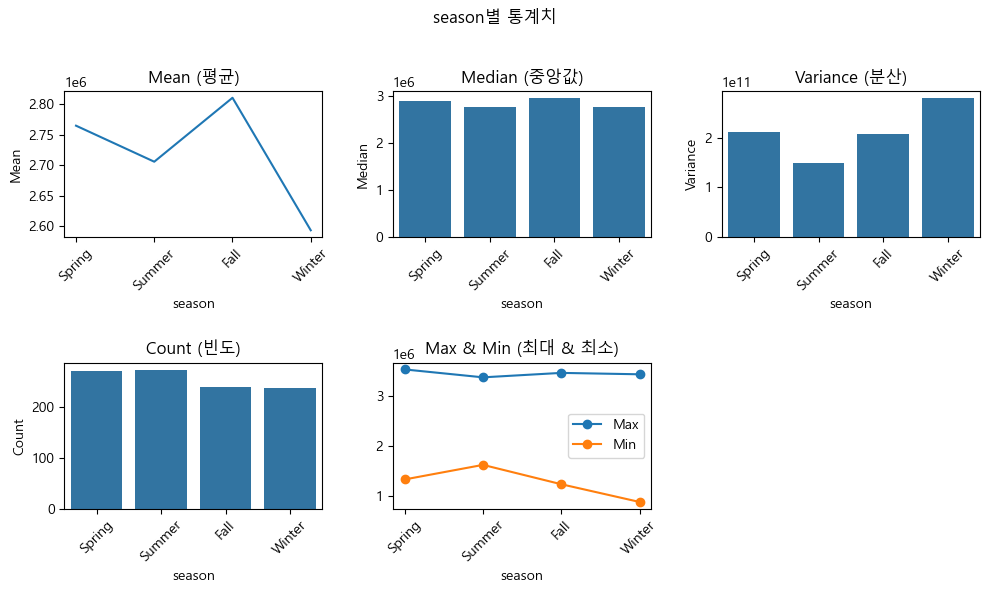

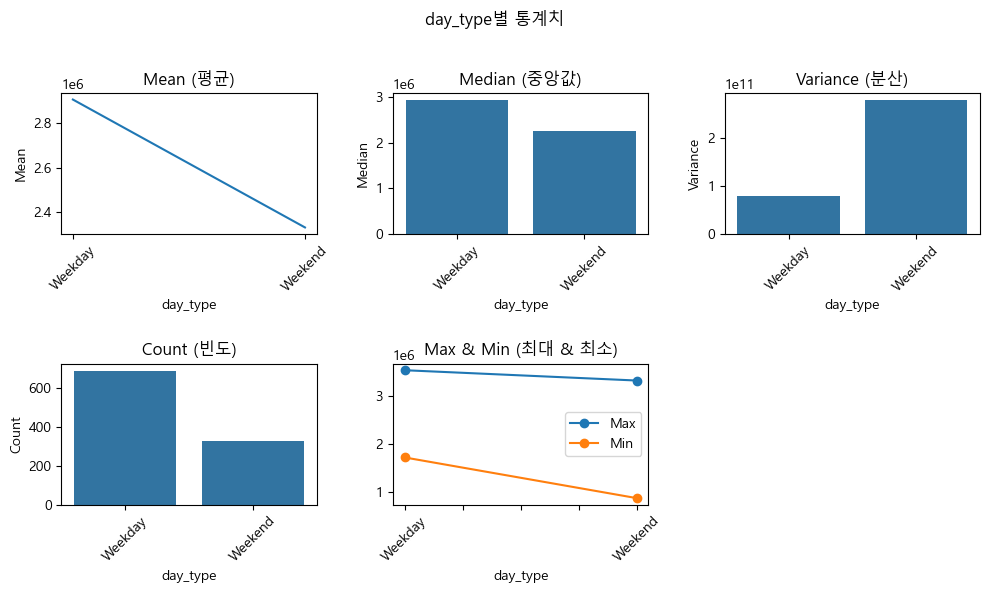

In [28]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_to1.items():
    plot_statistics(stats_df, key)

### 2-2. 두개 그룹 분석 - 연도와 계절, 연도와 평일/주말, 계절과 평일/주말

2-2-1. 분석을 위한 함수 정의

In [29]:
def group_analysis_by_two_columns(df, group_col1, group_col2, target_col):
    # 두 컬럼으로 그룹화
    grouped_df = df.groupby([group_col1, group_col2], observed=True)
    
    # 통계 계산 및 컬럼 이름 지정 (열 이름, 계산 방법)
    stats = grouped_df[target_col].agg([
    ("Max", "max"),
    ("Min", "min"),
    ("Mean", "mean"),
    ("Variance", "var"),
    ("Count", "count"),
    ("Median", "median"),                   # 중앙값
    ("Q1", lambda x: x.quantile(0.25)),     # 1사분위수 (Q1)
    ("Q3", lambda x: x.quantile(0.75)),     # 3사분위수 (Q3)
    ("IQR", lambda x: x.quantile(0.75) - x.quantile(0.25)),     # IQR
    ("Range", lambda x: x.max() - x.min())  # 범위
])
    return stats


2-2-2. 시각화를 위한 함수 

In [30]:
def create_double_group_plots(stats_dict, metric="Mean", figsize=(10, 5)):
    """
    Create visualization for double-grouped statistics
    
    Parameters:
    stats_dict: Dictionary containing the grouped statistics
    metric: The statistical measure to plot (e.g., "Mean", "Max", "Min")
    figsize: Size of the figure
    """
    
    def plot_heatmap(data, title, ax):
        # Reset index to get grouping columns as regular columns
        plot_data = data[metric].unstack()
        
        # Create heatmap
        sns.heatmap(plot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax)
        ax.set_title(title)
        plt.setp(ax.get_xticklabels(), rotation=45)
        plt.setp(ax.get_yticklabels(), rotation=0)

    def plot_line(data, title, ax):
        # Reset index to get grouping columns as regular columns
        plot_data = data[metric].unstack()
        
        # Plot lines
        plot_data.plot(marker='o', ax=ax)
        ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

    def plot_bar(data, title, ax):
        # Reset index to get grouping columns as regular columns
        plot_data = data[metric].unstack()
        
        # Plot bars
        plot_data.plot(kind='bar', ax=ax)
        ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.grid(True)

    # Create subplots for each group combination
    n_plots = len(stats_dict)
    n_rows = (n_plots + 1) // 2  # Round up division
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'{metric} Values by Different Groupings', fontsize=16, y=0.95)
    
    for i, (key, stats) in enumerate(stats_dict.items(), 1):
        ax = plt.subplot(n_rows, 2, i)
        
        # Choose plot type based on the data structure
        if 'year' in key:
            plot_line(stats, key, ax)
        elif 'season' in key:
            plot_bar(stats, key, ax)
        else:
            plot_heatmap(stats, key, ax)
            
    plt.tight_layout()
    plt.show()

2-2-3. 버스(전체) - 분석

In [31]:
# 버스 - 전체 함수실행

df_year_season_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "bus_total_passenger")
df_year_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "bus_total_passenger")
df_season_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "bus_total_passenger")

# 결과를 딕셔너리로 정리
double_group_stats_bt2 = {
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 버스 - 전체")
for key, value in double_group_stats_bt2.items():
    print(f"\n{key} Stats: (버스 - 전체)\n", value)

2. 이중 그룹 분석 - 버스 - 전체

year-season Stats: (버스 - 전체)
                    Max        Min          Mean      Variance  Count  \
year season                                                            
2022 Spring  5008393.0  1859371.0  3.964802e+06  7.631262e+11     91   
     Summer  5117110.0  2306090.0  4.220649e+06  6.861269e+11     91   
     Fall    5170794.0  1790701.0  4.226218e+06  8.851855e+11     88   
     Winter  5156498.0  1400020.0  3.725443e+06  9.194136e+11     87   
2023 Spring  5017987.0  2374062.0  4.283860e+06  7.604565e+11     90   
     Summer  5036894.0  2304063.0  4.210297e+06  7.002657e+11     92   
     Fall    5063317.0  1725294.0  4.192080e+06  8.653003e+11     91   
     Winter  4946766.0  1523468.0  3.962253e+06  8.503267e+11     90   
2024 Spring  5110526.0  2423881.0  4.337490e+06  6.855833e+11     88   
     Summer  5235636.0  2603371.0  4.362821e+06  6.858100e+11     89   
     Fall    5338460.0  1929347.0  4.385537e+06  9.815060e+11     60   
     Winter

2-2-4. 버스(전체) - 시각화

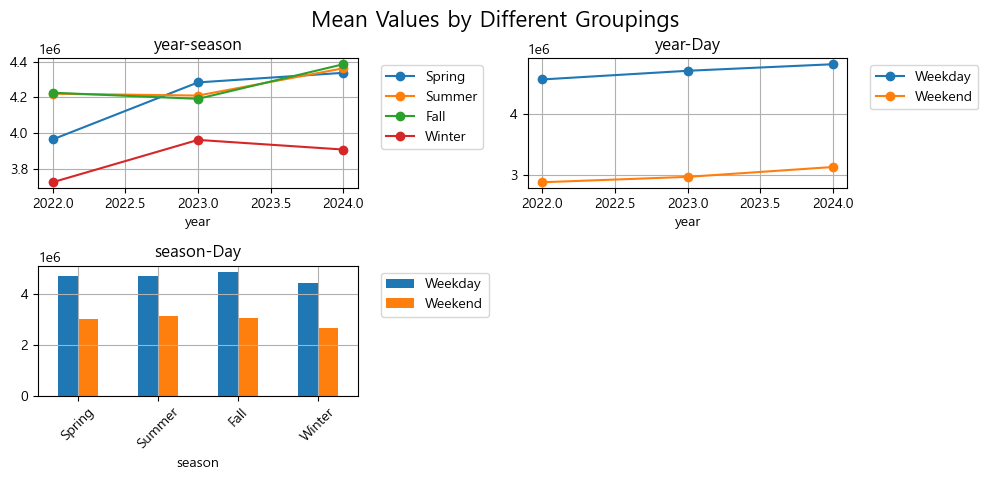

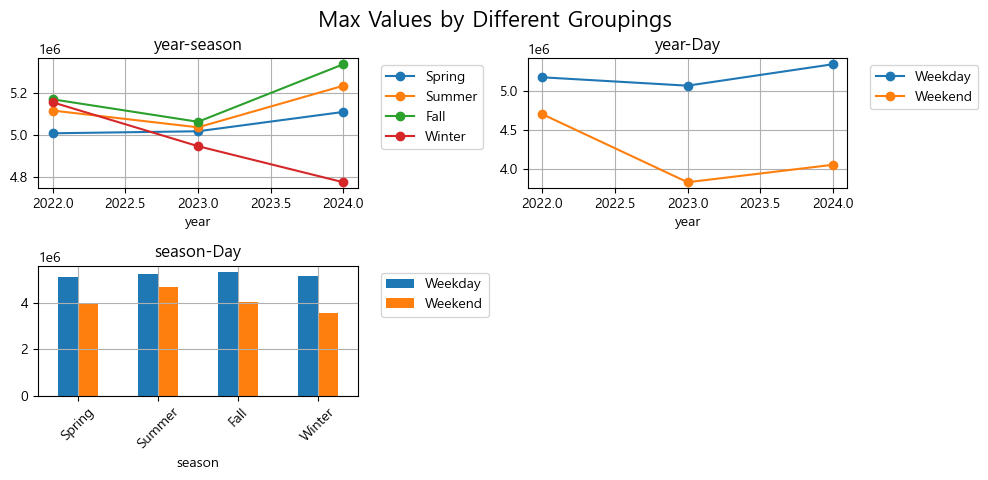

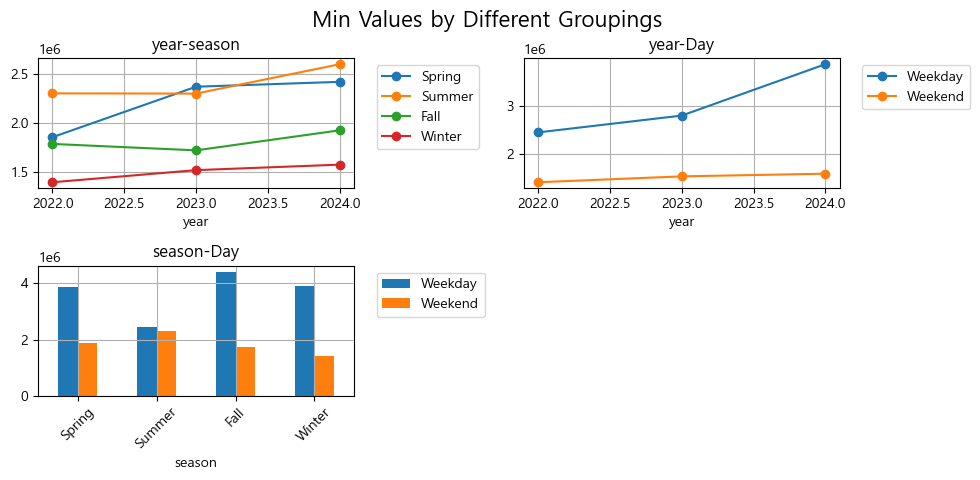

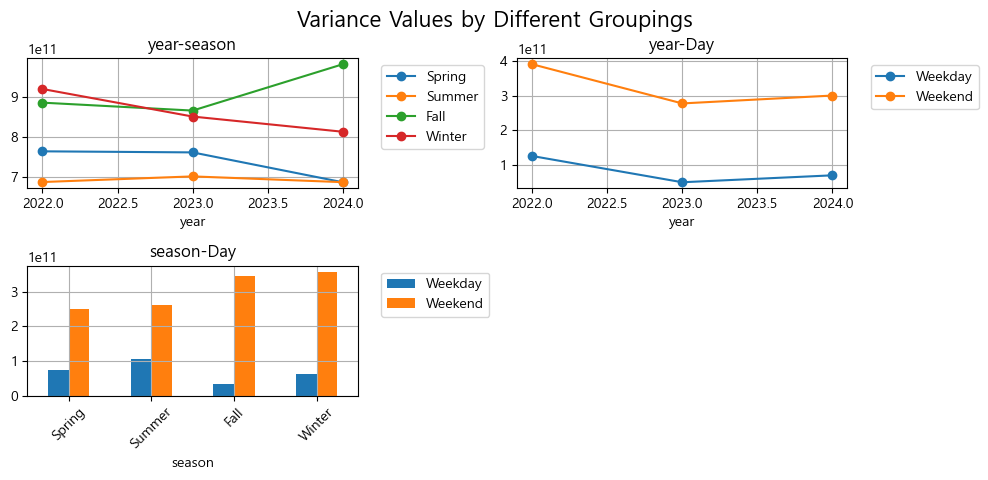

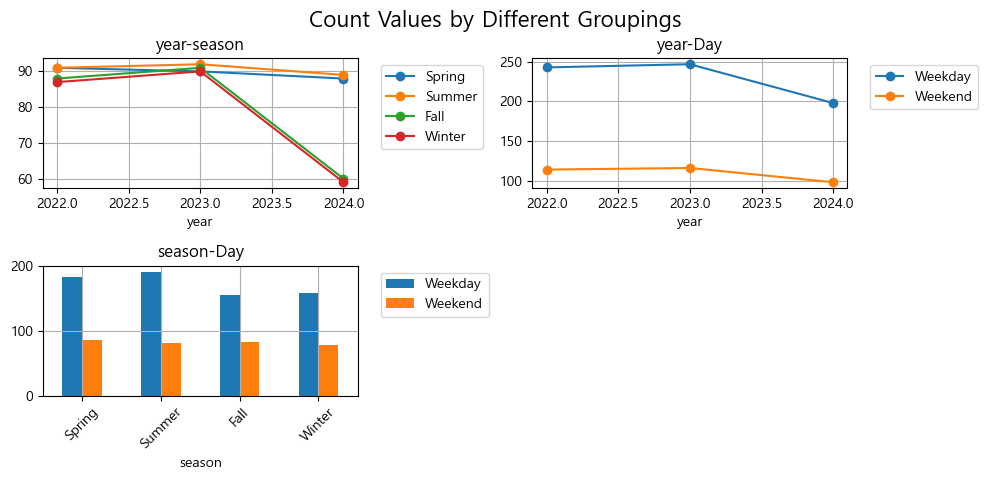

In [32]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_bt2, metric=metric)

2-2-5. 지하철(전체) - 분석

In [33]:
# 지하철 - 전체 함수실행

df_year_season_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "train_total_passenger")
df_year_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "train_total_passenger")
df_season_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "train_total_passenger")

# 결과를 딕셔너리로 정리
double_group_stats_tt2 = {
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 지하철 - 전체")
for key, value in double_group_stats_tt2.items():
    print(f"\n{key} Stats: (지하철 - 전체)\n", value)

2. 이중 그룹 분석 - 지하철 - 전체

year-season Stats: (지하철 - 전체)
                    Max        Min          Mean      Variance  Count  \
year season                                                            
2022 Spring  5621093.0  1885163.0  4.290766e+06  1.050899e+12     91   
     Summer  5532904.0  2342500.0  4.561754e+06  9.600096e+11     91   
     Fall    5838293.0  1741406.0  4.777088e+06  1.231026e+12     88   
     Winter  5787969.0  1241418.0  4.155691e+06  1.398068e+12     87   
2023 Spring  6102612.0  2646927.0  5.042247e+06  1.176392e+12     90   
     Summer  5914655.0  2460261.0  4.786904e+06  1.088545e+12     92   
     Fall    6069420.0  1884127.0  4.932781e+06  1.348394e+12     91   
     Winter  5887566.0  1563805.0  4.704864e+06  1.384936e+12     90   
2024 Spring  6232284.0  2764175.0  5.152012e+06  1.160893e+12     88   
     Summer  5993030.0  2651942.0  4.877536e+06  1.113207e+12     89   
     Fall    6121264.0  1883438.0  4.877539e+06  1.516406e+12     60   
     Wint

2-2-6. 지하철(전체) - 시각화

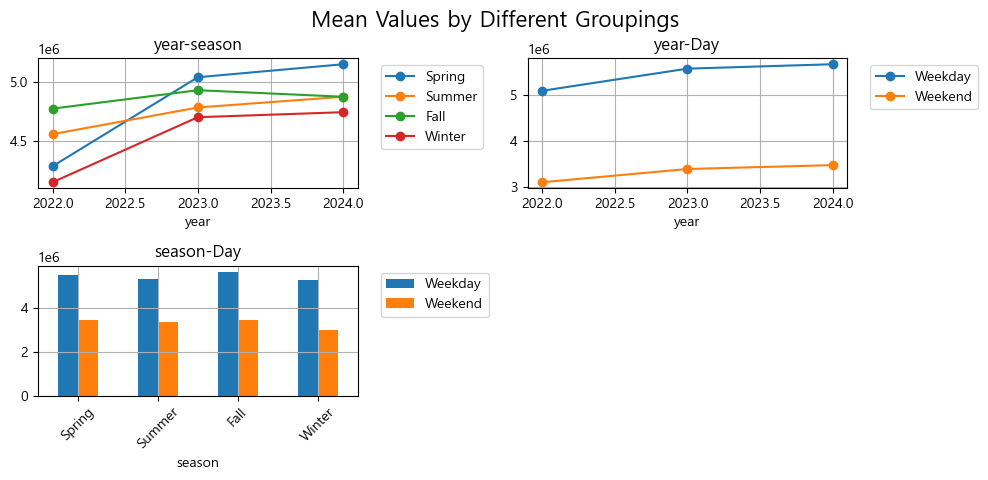

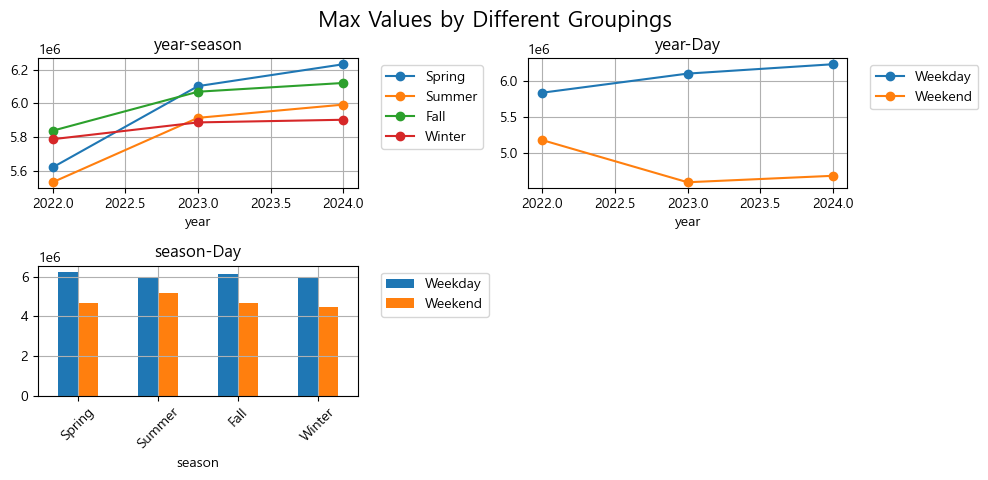

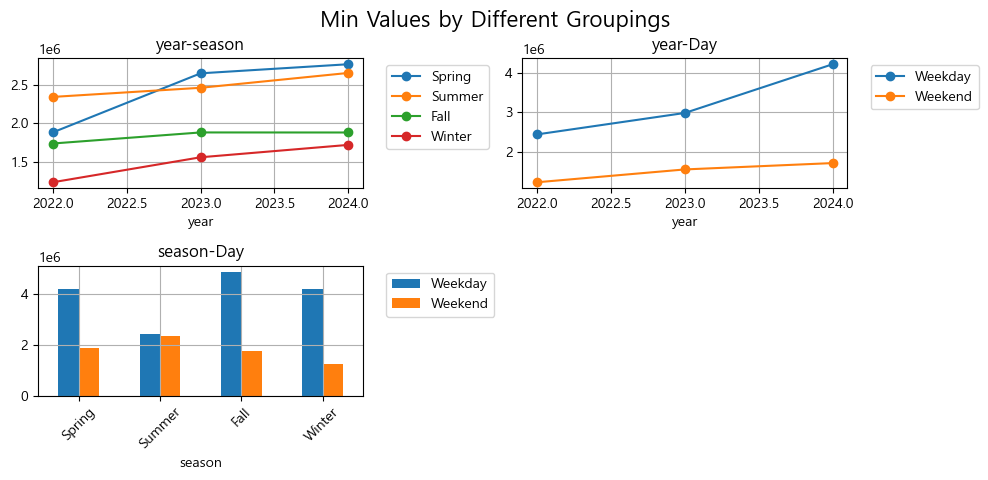

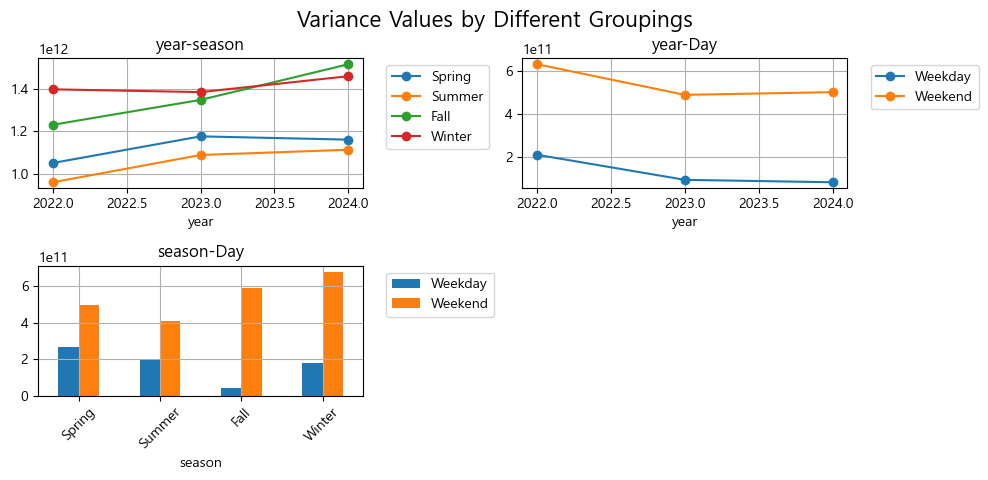

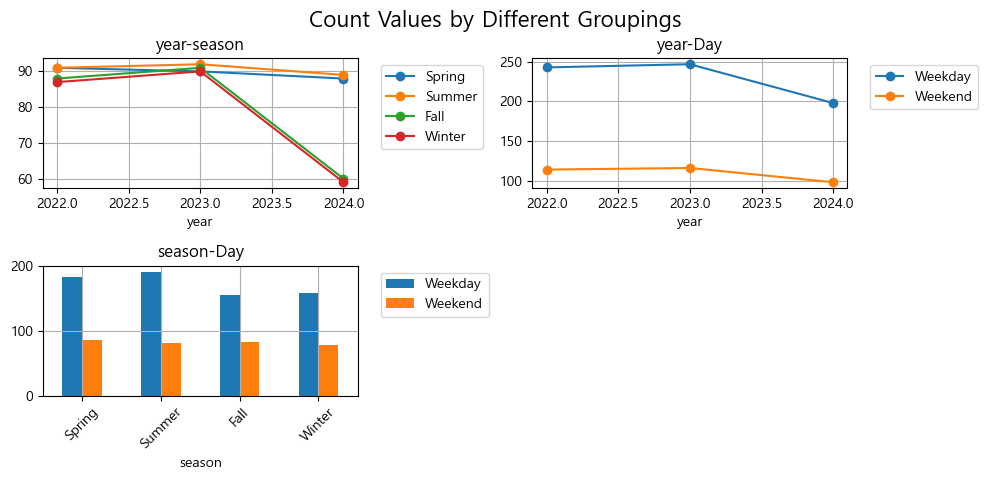

In [34]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_tt2, metric=metric)

2-2-7. 버스(통근자) - 분석

In [35]:
# 버스 - 통근자 함수실행

df_year_season_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "bus_commute_passenger")
df_year_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "bus_commute_passenger")
df_season_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "bus_commute_passenger")

# 결과를 딕셔너리로 정리
double_group_stats_bc2 = {
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 버스 - 통근자")
for key, value in double_group_stats_bc2.items():
    print(f"\n{key} Stats: (버스 - 통근자)\n", value)

2. 이중 그룹 분석 - 버스 - 통근자

year-season Stats: (버스 - 통근자)
                    Max       Min          Mean      Variance  Count  \
year season                                                           
2022 Spring  2129665.0  543249.0  1.577052e+06  2.818825e+11     91   
     Summer  2177050.0  700163.0  1.684617e+06  2.682119e+11     91   
     Fall    2166383.0  535759.0  1.671048e+06  3.238181e+11     88   
     Winter  2187229.0  409493.0  1.460970e+06  3.030401e+11     87   
2023 Spring  2128651.0  710050.0  1.703866e+06  2.953217e+11     90   
     Summer  2092669.0  691292.0  1.664771e+06  2.664409e+11     92   
     Fall    2140038.0  515131.0  1.638453e+06  3.101997e+11     91   
     Winter  2067792.0  453036.0  1.542570e+06  2.944980e+11     90   
2024 Spring  2128253.0  718761.0  1.683552e+06  2.811811e+11     88   
     Summer  2136107.0  777431.0  1.697650e+06  2.632183e+11     89   
     Fall    2258019.0  569384.0  1.674266e+06  3.419766e+11     60   
     Winter  2031282.0

2-2-8. 버스(통근자) - 시각화

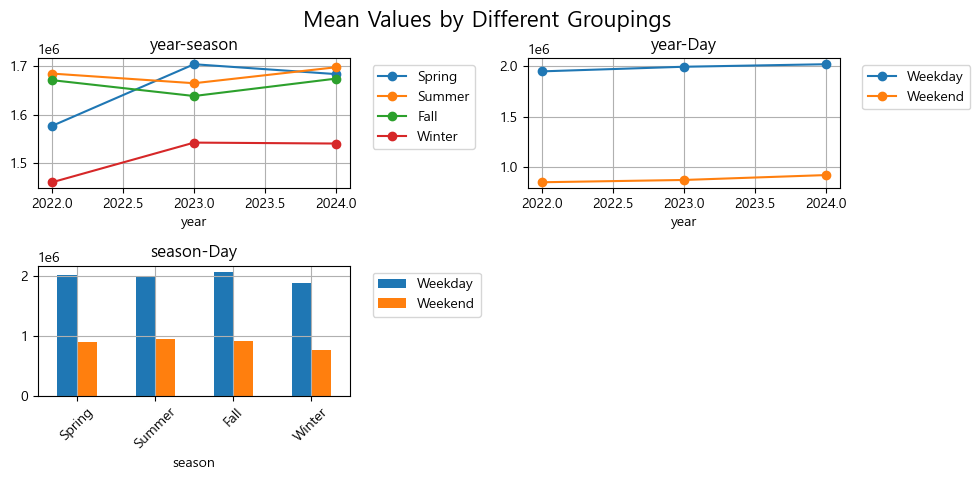

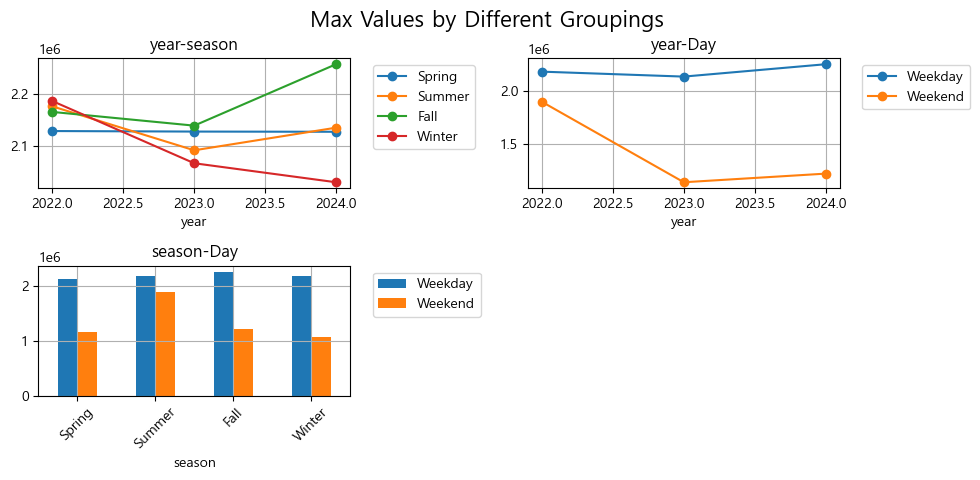

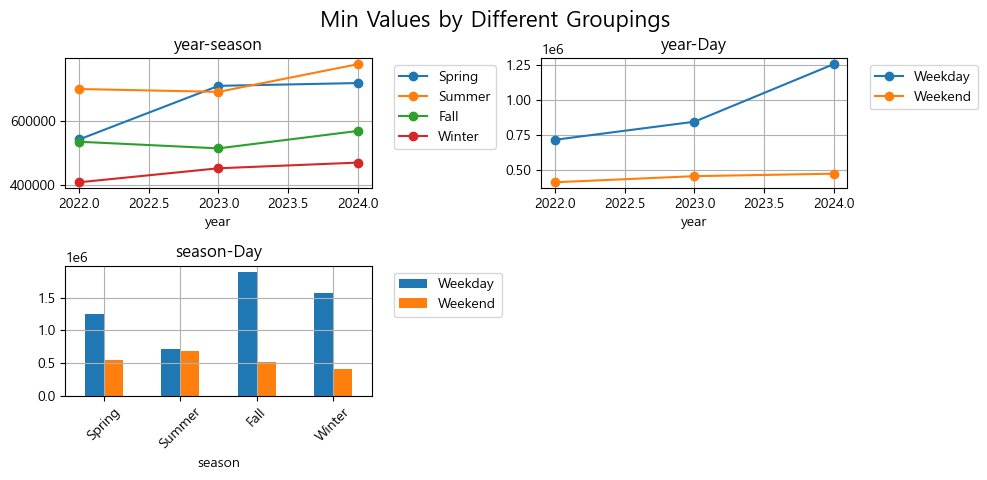

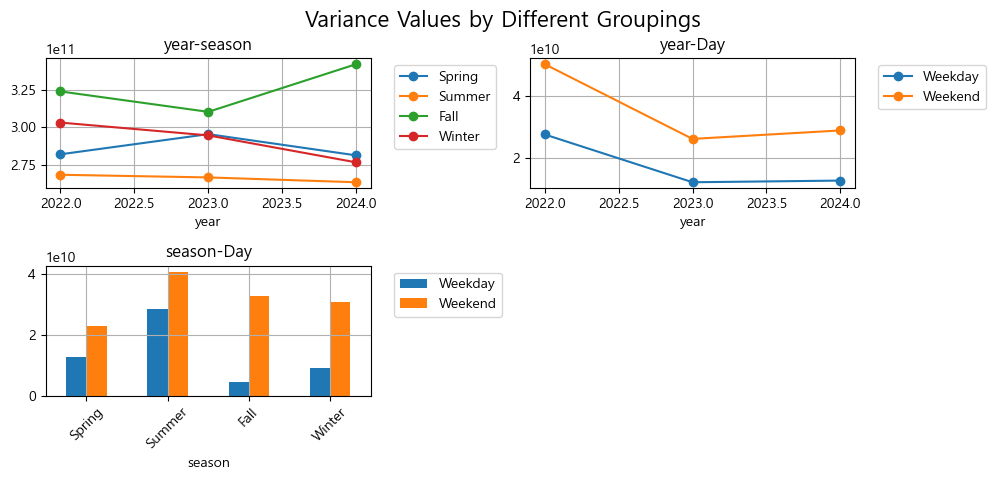

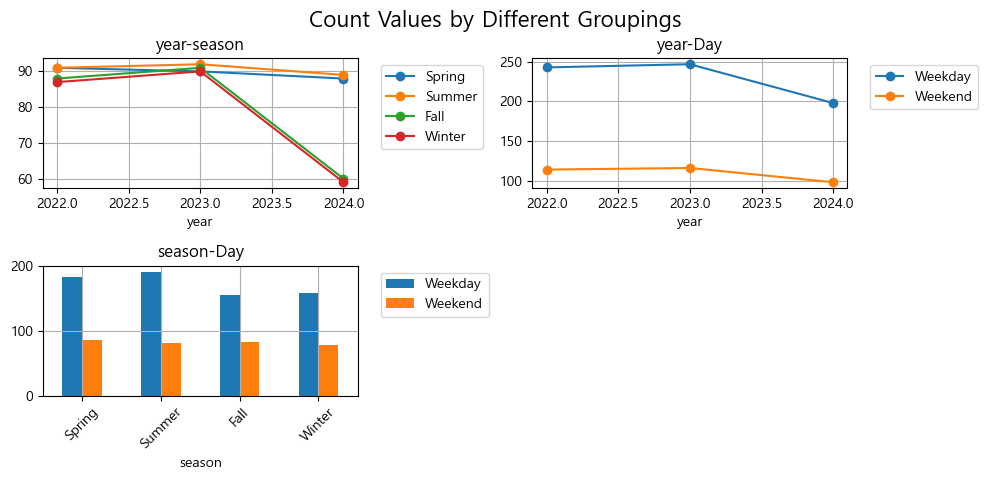

In [36]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_bc2, metric=metric)

2-2-9. 지하철(통근자) - 분석

In [37]:
# 지하철 - 통근자 함수실행

df_year_season_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "train_commute_passenger")
df_year_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "train_commute_passenger")
df_season_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "train_commute_passenger")

# 결과를 딕셔너리로 정리
double_group_stats_tc2 = {
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 지하철 - 통근자")
for key, value in double_group_stats_tc2.items():
    print(f"\n{key} Stats: (지하철 - 통근자)\n", value)

2. 이중 그룹 분석 - 지하철 - 통근자

year-season Stats: (지하철 - 통근자)
                    Max       Min          Mean      Variance  Count  \
year season                                                           
2022 Spring  2615511.0  553553.0  1.869104e+06  4.944780e+11     91   
     Summer  2546878.0  719067.0  1.990331e+06  4.750773e+11     91   
     Fall    2635534.0  506430.0  2.042199e+06  5.798400e+11     88   
     Winter  2639540.0  362195.0  1.781391e+06  5.524479e+11     87   
2023 Spring  2733565.0  796090.0  2.159246e+06  5.801597e+11     90   
     Summer  2650264.0  738426.0  2.050681e+06  5.181600e+11     92   
     Fall    2707430.0  550847.0  2.081379e+06  6.102545e+11     91   
     Winter  2622596.0  446118.0  1.976757e+06  5.946111e+11     90   
2024 Spring  2780549.0  826903.0  2.153951e+06  5.855088e+11     88   
     Summer  2719393.0  816426.0  2.066163e+06  5.266051e+11     89   
     Fall    2723203.0  539423.0  2.019371e+06  6.492113e+11     60   
     Winter  2648708

2-2-10. 지하철(통근자) - 시각화

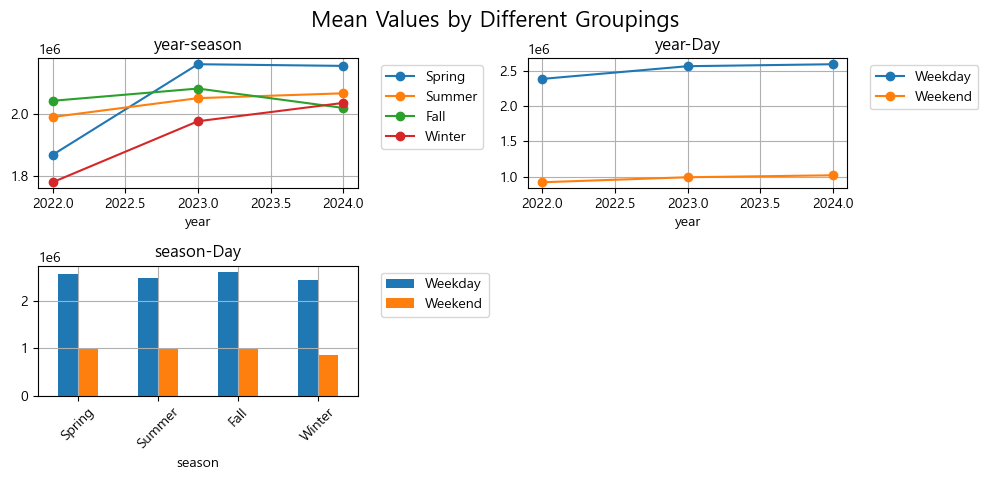

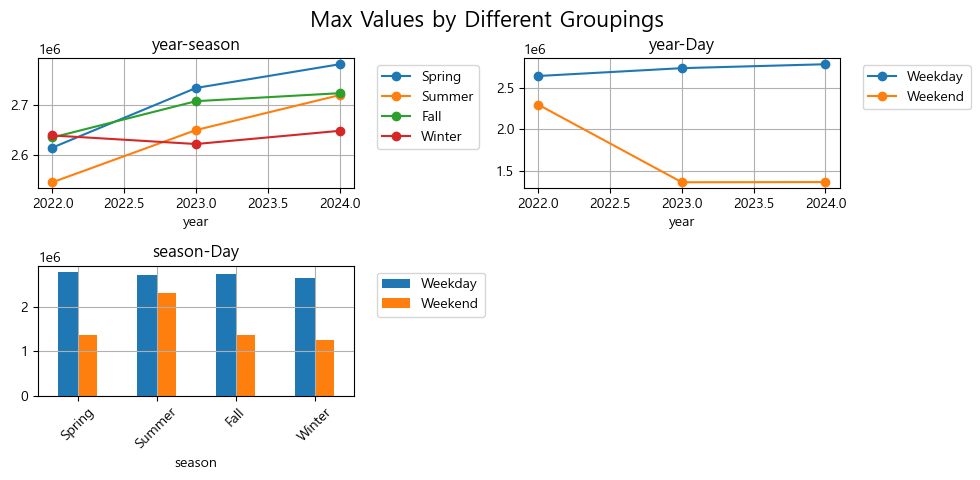

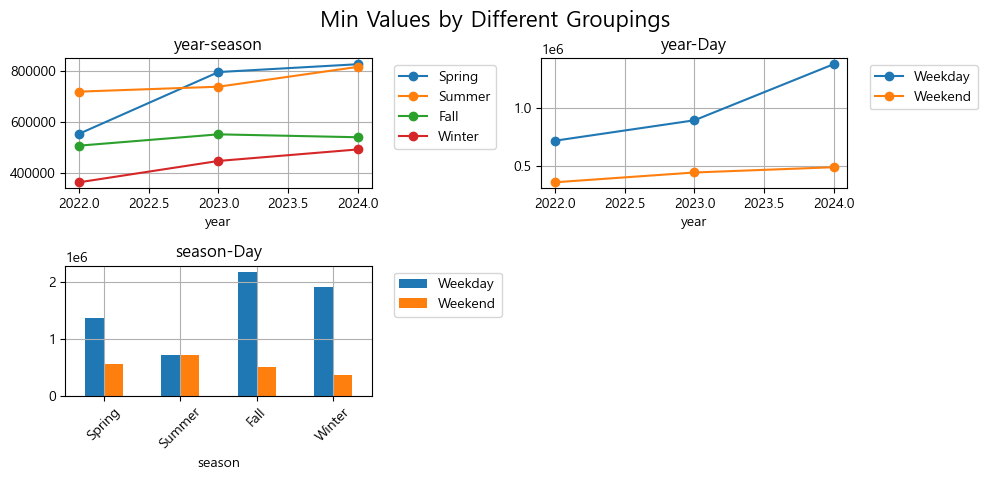

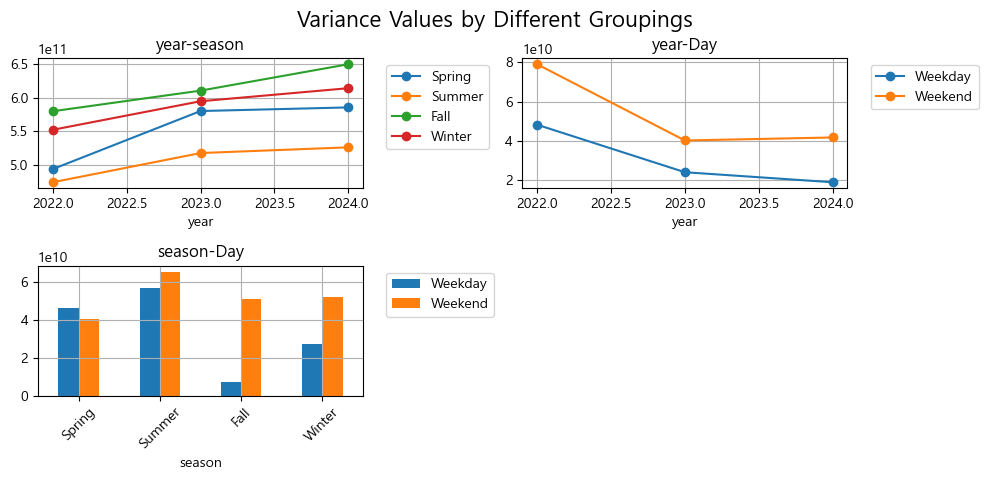

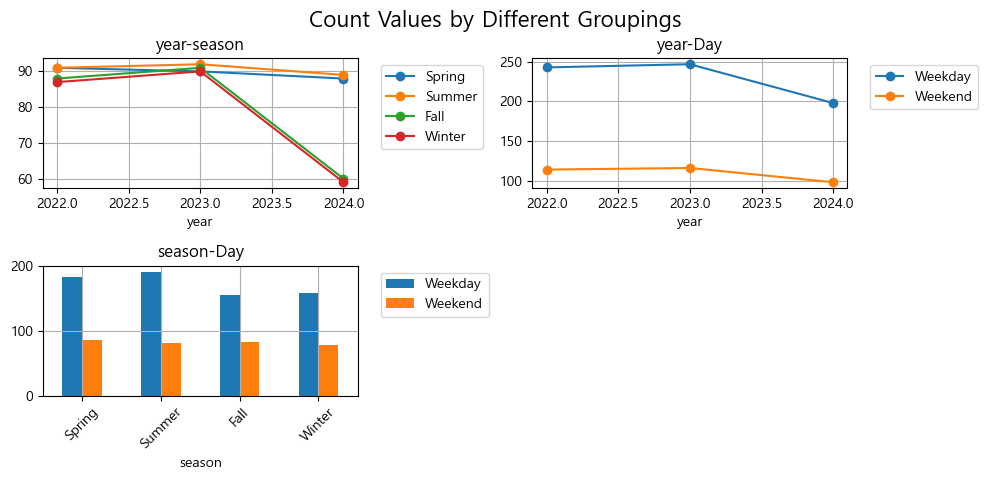

In [38]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_tc2, metric=metric)

2-2-11. 버스(비통근자) - 분석

In [39]:
# 버스 - 비통근자 함수실행

df_year_season_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "bus_other_passenger")
df_year_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "bus_other_passenger")
df_season_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "bus_other_passenger")

# 결과를 딕셔너리로 정리
double_group_stats_bo2 = {
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 버스 - 비통근자")
for key, value in double_group_stats_bo2.items():
    print(f"\n{key} Stats: (버스 - 비통근자)\n", value)

2. 이중 그룹 분석 - 버스 - 비통근자

year-season Stats: (버스 - 비통근자)
                    Max        Min          Mean      Variance  Count  \
year season                                                            
2022 Spring  2962910.0  1316122.0  2.387750e+06  1.406496e+11     91   
     Summer  3001668.0  1605927.0  2.536032e+06  1.139843e+11     91   
     Fall    3093871.0  1254942.0  2.555171e+06  1.625359e+11     88   
     Winter  2969269.0   990527.0  2.264473e+06  1.973726e+11     87   
2023 Spring  2988172.0  1648956.0  2.579994e+06  1.232306e+11     90   
     Summer  2989034.0  1612771.0  2.545526e+06  1.215517e+11     92   
     Fall    3044911.0  1210163.0  2.553627e+06  1.589311e+11     91   
     Winter  2933474.0  1070432.0  2.419683e+06  1.697999e+11     90   
2024 Spring  3051702.0  1705120.0  2.653938e+06  1.065297e+11     88   
     Summer  3129161.0  1825940.0  2.665171e+06  1.149172e+11     89   
     Fall    3255236.0  1359963.0  2.711270e+06  1.890317e+11     60   
     Wi

2-2-12. 버스(비통근자) - 시각화

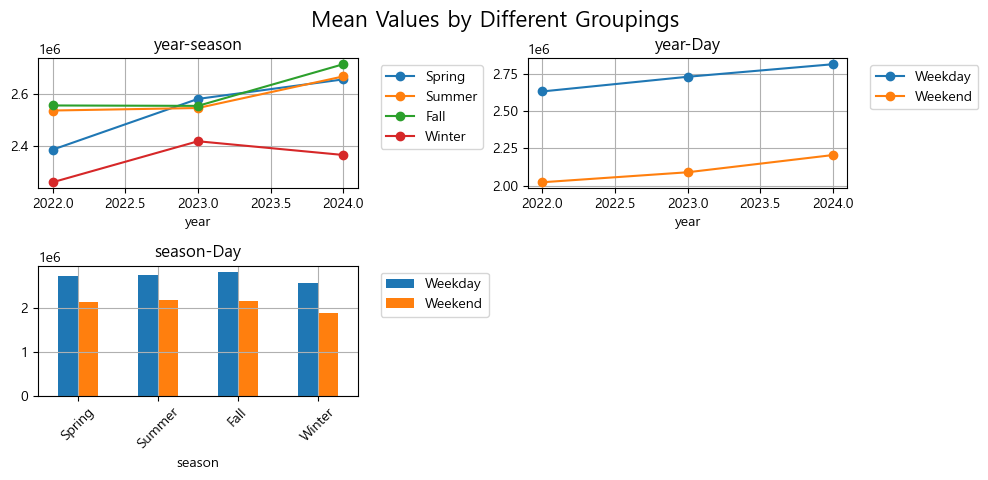

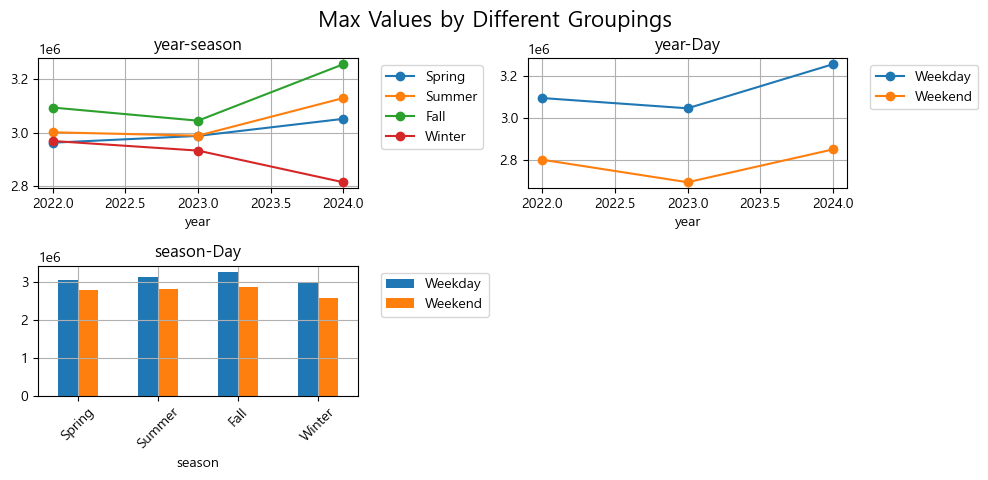

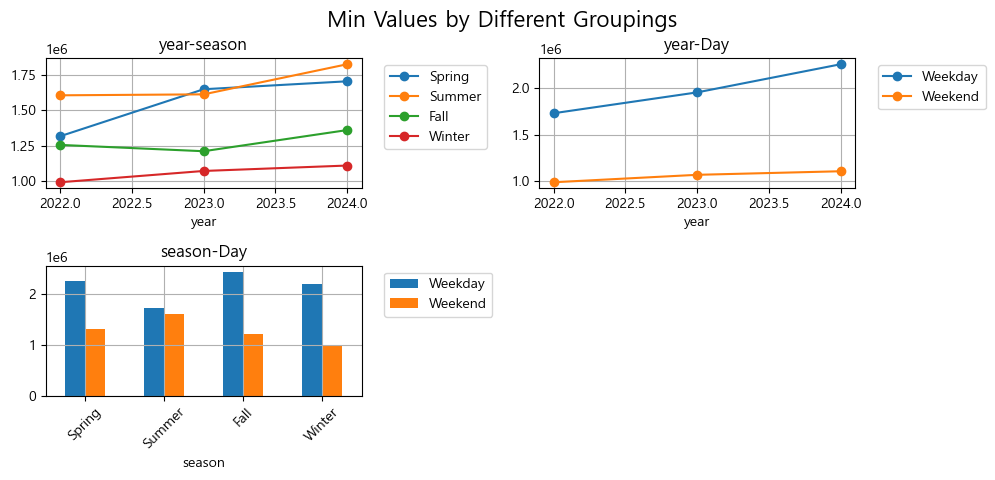

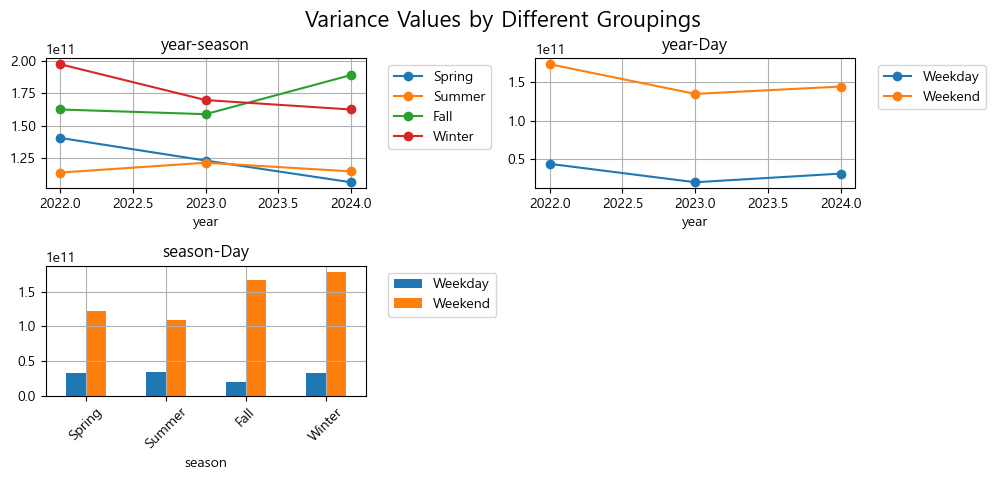

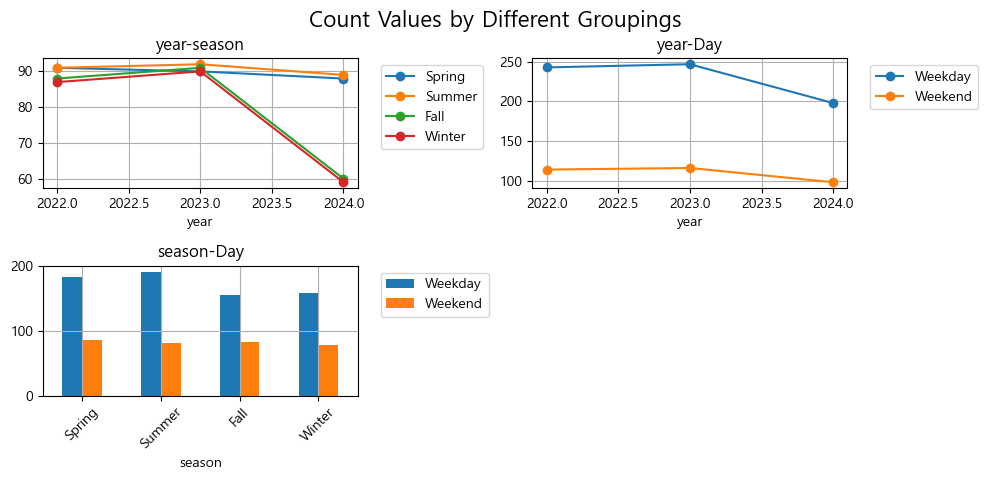

In [40]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_bo2, metric=metric)

2-2-13. 지하철(비통근자) - 분석

In [41]:
# 지하철 - 비통근자 함수실행

df_year_season_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "train_other_passenger")
df_year_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "train_other_passenger")
df_season_day_stats = group_analysis_by_two_columns(
    df = merged_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "train_other_passenger")

# 결과를 딕셔너리로 정리
double_group_stats_to2 = {
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 지하철 - 비통근자")
for key, value in double_group_stats_to2.items():
    print(f"\n{key} Stats: (지하철 - 비통근자)\n", value)

2. 이중 그룹 분석 - 지하철 - 비통근자

year-season Stats: (지하철 - 비통근자)
                    Max        Min          Mean      Variance  Count  \
year season                                                            
2022 Spring  3100199.0  1331610.0  2.421662e+06  1.560102e+11     91   
     Summer  3047669.0  1623433.0  2.571423e+06  1.209546e+11     91   
     Fall    3264191.0  1234976.0  2.734889e+06  1.859895e+11     88   
     Winter  3261356.0   879223.0  2.374300e+06  2.834567e+11     87   
2023 Spring  3437569.0  1850837.0  2.883001e+06  1.481025e+11     90   
     Summer  3343544.0  1721835.0  2.736223e+06  1.485101e+11     92   
     Fall    3395858.0  1333280.0  2.851403e+06  1.991163e+11     91   
     Winter  3441575.0  1117687.0  2.728106e+06  2.354447e+11     90   
2024 Spring  3538816.0  1937272.0  2.998061e+06  1.480366e+11     88   
     Summer  3380453.0  1827588.0  2.811373e+06  1.488348e+11     89   
     Fall    3469738.0  1344015.0  2.858168e+06  2.437746e+11     60   
     

2-2-14. 지하철(비통근자) - 시각화

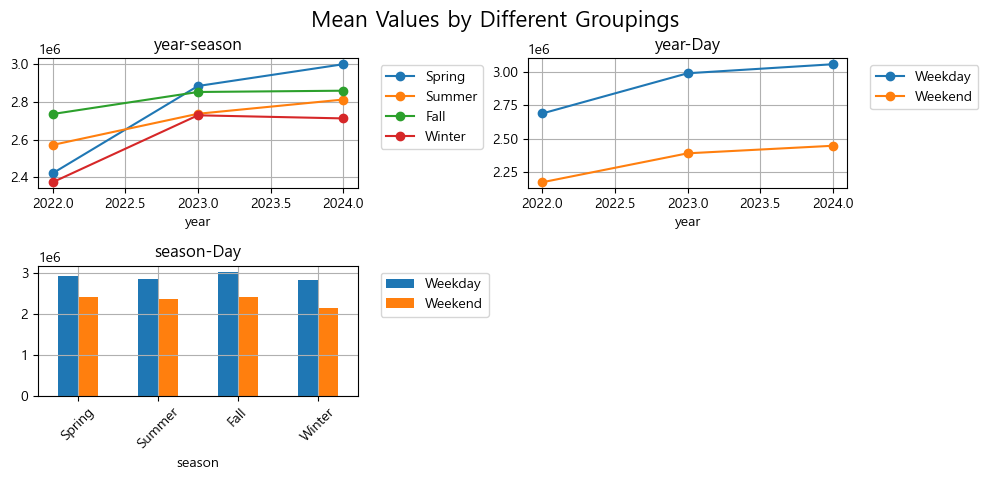

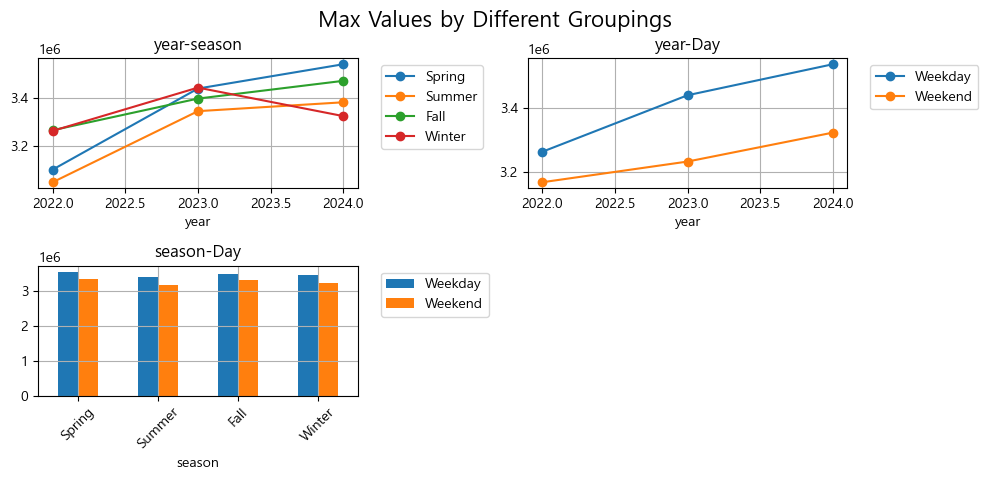

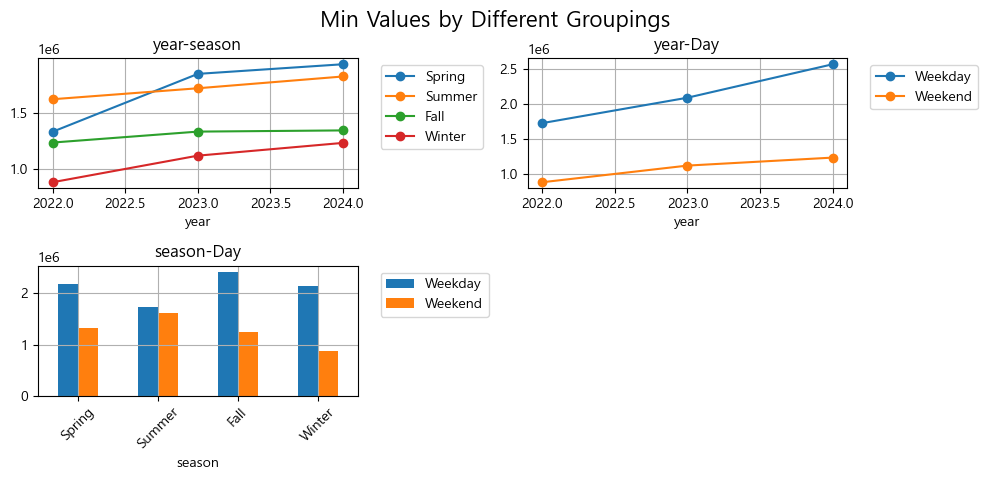

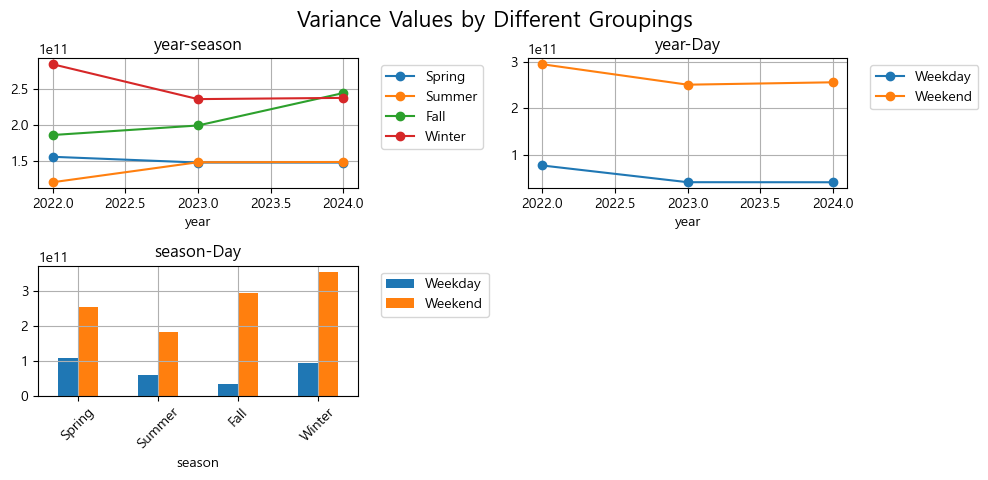

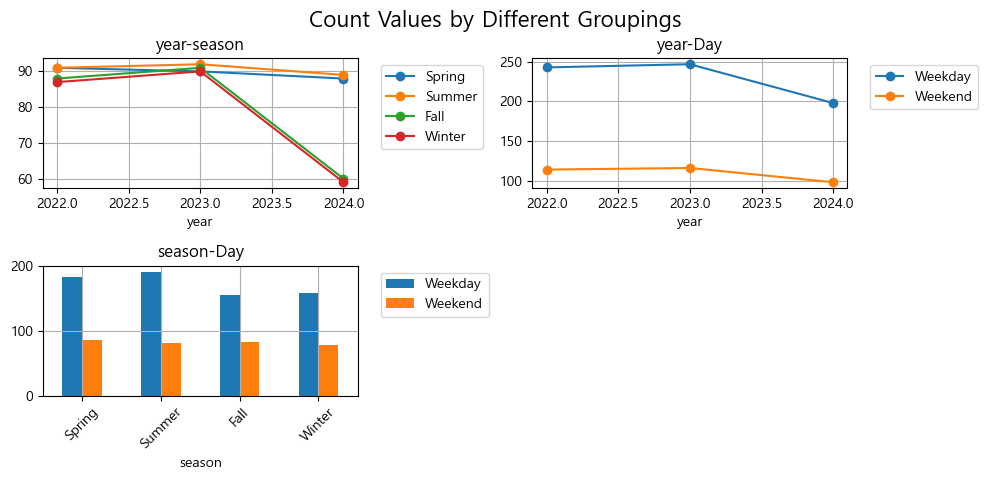

In [42]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_to2, metric=metric)

기타작업

In [43]:
merged_df.to_csv("data/all_merged_data.csv")

# 3. 데이터 분석 및 시각화 - 대중교통 이용자와 날씨

### 3-1. 정규화

3-1-1. 분포 확인하기

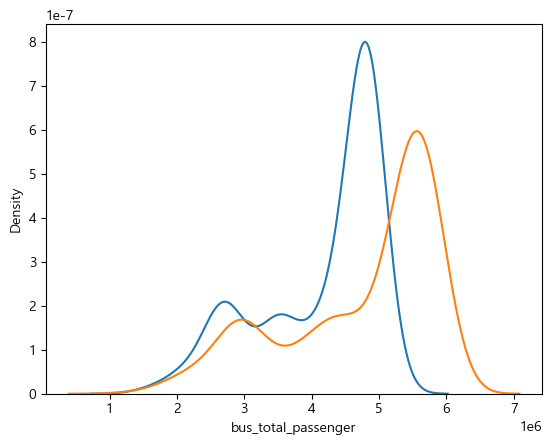

In [44]:
# 정규성 검정 - 승객 수
sns.kdeplot(data=merged_df["bus_total_passenger"])
sns.kdeplot(data=merged_df["train_total_passenger"])
plt.show()

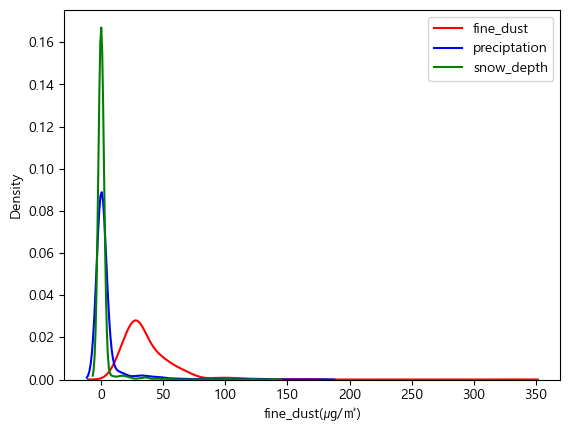

In [45]:
# 정규성 검정 - 미세먼지, 강수량, 적설량
sns.kdeplot(data=merged_df["fine_dust(㎍/㎥)"], color='red', label="fine_dust")
sns.kdeplot(data=merged_df["precipitation(mm)"], color='blue', label="preciptation")
sns.kdeplot(data=merged_df["snow_depth(mm)"], color='green', label="snow_depth")
plt.legend()
plt.show()

In [46]:
# 승객수와 날씨 데이터가 정규분포와는 거리가 멀어 보여, 
# StandardScaler대신 MinMaxScaler를 사용하기로 결정

3-2-1. 최소-최대 정규화하기

In [47]:
# 승객 데이터와 날씨 데이터간 수치상 차이가 심하여 정규화 함

# 정규화할 컬럼 선택
cols_to_normalize = [
    'bus_total_passenger', 'bus_commute_passenger', 'bus_other_passenger',
    'train_total_passenger', 'train_commute_passenger', 'train_other_passenger', 
    'fine_dust(㎍/㎥)', 'precipitation(mm)', 'snow_depth(mm)'
]

# MinMaxScaler 객체 생성 및 적용
# 기온이 대략 -15~35 사이이므로 다른 데이터들이 이와 유사한 값이 나오도록 
# feature_range=(0, 50)을 지정하여 0~50까지로 변환
scaler = MinMaxScaler(feature_range=(0, 50))

merged_df[cols_to_normalize] = scaler.fit_transform(merged_df[cols_to_normalize])

# 확인하기
merged_df.head()

date  bus_total_passenger  bus_commute_passenger  \
365 2022-01-01             5.826342               2.978860   
366 2022-01-02             8.234377               4.594120   
367 2022-01-03            33.372287              37.447675   
368 2022-01-04            34.924894              38.255697   
369 2022-01-05            34.924894              38.255697   

     bus_other_passenger  train_total_passenger  train_commute_passenger  \
365             7.700857               5.523160                 2.901519   
366            10.570122               8.132757                 5.086455   
367            27.470086              32.521911                39.773003   
368            29.510613              34.128245                40.396815   
369            29.510613              34.128245                40.396815   

     train_other_passenger  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  \
365               7.726163        4.000000      -4.3     -10.2       2.3   
366              10.636458        5.230769      -1.3      -5.2       3.0   
367              24.863692        3.076923      -1.9      -8.0       2.5   
368              27.310833        4.461538      -2.5      -5.6       1.0   
369              27.310833        6.769231      -2.8      -7.8       1.9   

     precipitation(mm)  snow_depth(mm)  season  year fd_grade p_grade  \
365           0.000000        0.000000  Winter  2022   Normal     Dry   
366           0.085131        1.811594  Winter  2022   Normal   Light   
367           0.000000        0.000000  Winter  2022     Good     Dry   
368           0.000000        0.000000  Winter  2022   Normal     Dry   
369           0.000000        0.000000  Winter  2022   Normal     Dry   

        s_grade at_grade day_type  
365     No_Snow     Cold  Weekend  
366  Light_Snow     Cold  Weekend  
367     No_Snow     Cold  Weekday  
368     No_Snow     Cold  Weekday  
369     No_Snow     Cold  Weekday

### 3-2. 두 변수의 관계 - 상관계수/히트맵

3-2-1. 평균기온과 버스 통근자

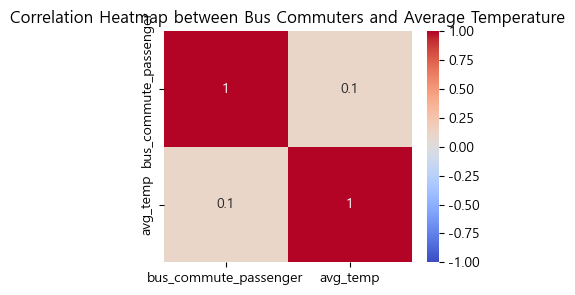

In [48]:
# 평균기온과 버스 통근자 간의 상관계수 계산
corr_matrix = merged_df[['bus_commute_passenger', 'avg_temp']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Bus Commuters and Average Temperature')
plt.show()

3-2-2. 평균기온과 지하철 통근자

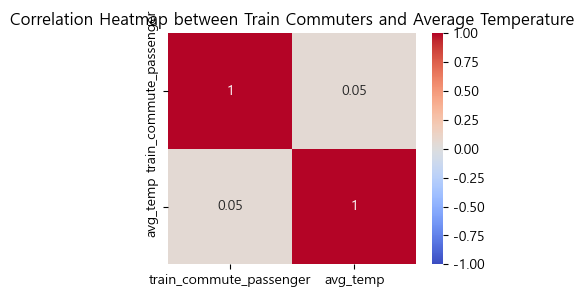

In [49]:
# 평균기온과 지하철 통근자 간의 상관계수 계산
corr_matrix = merged_df[['train_commute_passenger', 'avg_temp']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Train Commuters and Average Temperature')
plt.show()

3-2-3. 평균기온과 버스 비통근자

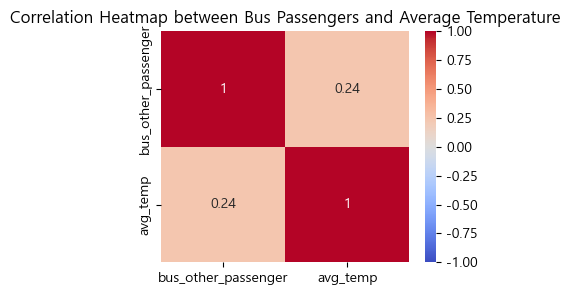

In [50]:
# 평균기온과 버스 비통근자 간의 상관계수 계산
corr_matrix = merged_df[['bus_other_passenger', 'avg_temp']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Bus Passengers and Average Temperature')
plt.show()

3-2-4. 평균기온과 지하철 비통근자

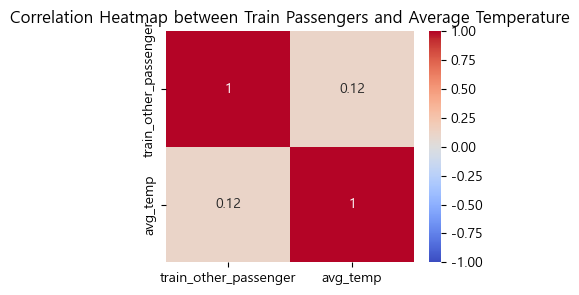

In [51]:
# 평균기온과 지하철 비통근자 간의 상관계수 계산
corr_matrix = merged_df[['train_other_passenger', 'avg_temp']].corr()
 
# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Train Passengers and Average Temperature')
plt.show()

3-2-5. 미세먼지와 버스 전체 이용자

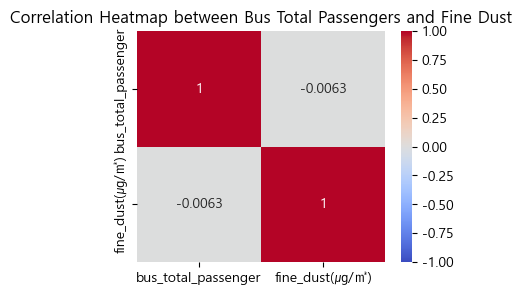

In [52]:
# 미세먼지와 버스 전체 이용자 간의 상관계수 계산
corr_matrix = merged_df[['bus_total_passenger', 'fine_dust(㎍/㎥)']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Bus Total Passengers and Fine Dust')
plt.show()

3-2-6. 미세먼지와 지하철 전체 이용자

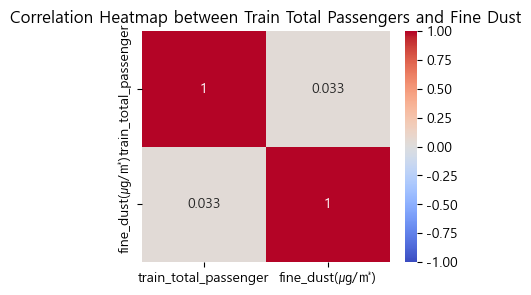

In [53]:
# 미세먼지와 지하철 전체 이용자 간의 상관계수 계산
corr_matrix = merged_df[['train_total_passenger', 'fine_dust(㎍/㎥)']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Train Total Passengers and Fine Dust')
plt.show()

3-2-7. 강수량과 버스 전체 이용자

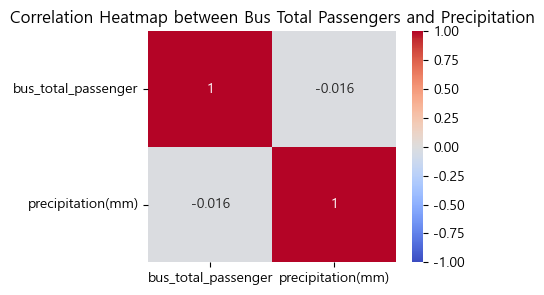

In [54]:
# 강수량과 버스 전체 이용자 간의 상관계수 계산
corr_matrix = merged_df[['bus_total_passenger', 'precipitation(mm)']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Bus Total Passengers and Precipitation')
plt.show()

3-2-8. 강수량과 지하철 전체 이용자

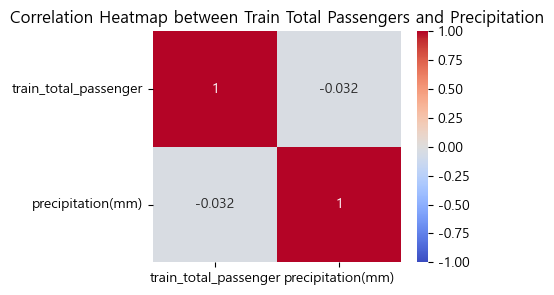

In [55]:
# 강수량과 지하철 전체 이용자 간의 상관계수 계산
corr_matrix = merged_df[['train_total_passenger', 'precipitation(mm)']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Train Total Passengers and Precipitation')
plt.show()

3-2-9. 적설량과 버스 전체 이용자

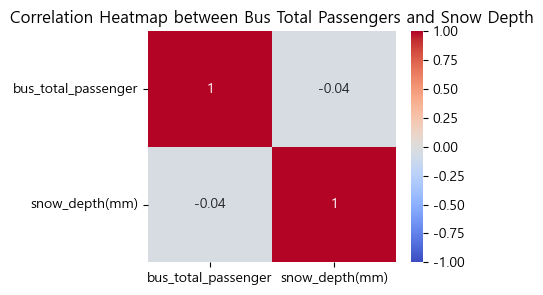

In [56]:
# 적설량과 버스 전체 이용자 간의 상관계수 계산
corr_matrix = merged_df[['bus_total_passenger', 'snow_depth(mm)']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Bus Total Passengers and Snow Depth')
plt.show()

3-2-10. 적설량과 지하철 전체 이용자

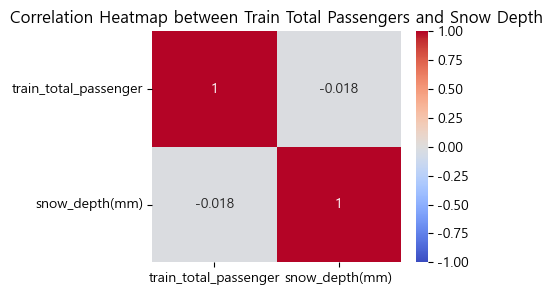

In [57]:
# 적설량과 지하철 전체 이용자 간의 상관계수 계산
corr_matrix = merged_df[['train_total_passenger', 'snow_depth(mm)']].corr()

# 히트맵 그리기
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Train Total Passengers and Snow Depth')
plt.show()

### 3-3. 두 변수의 관계 - 카이제곱 검정

3-3-1. 카이제곱 검정을 위한 비통근자 함수생성

In [58]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임에서 승객 데이터를 범주화하고 교차표 생성
def create_contingency_tables(df, category_col):
    """
    데이터프레임에서 승객 데이터를 범주화하고 교차표 생성
    
    Args:
        df: 분석할 데이터프레임
        category_col: 분석할 범주형 컬럼명 (예: 'season' 또는 'p_grade')
    """
    # 비통근 승객 수 합계 계산 및 3분위수로 범주화
    df['total_other'] = df['bus_other_passenger'] + df['train_other_passenger']
    df['other_category'] = pd.qcut(df['total_other'], q=3, labels=['Low', 'Medium', 'High'])
    
    # 평일/주말 데이터 분리 (day_type이 0이면 평일, 1이면 주말/공휴일)
    weekday_data = df[df['day_type'] == "Weekday"]
    weekend_data = df[df['day_type'] == "Weekend"]
    
    # 교차표 생성
    weekday_contingency = pd.crosstab(weekday_data[category_col], weekday_data['other_category'])
    weekend_contingency = pd.crosstab(weekend_data[category_col], weekend_data['other_category'])
    
    return weekday_contingency, weekend_contingency

# 카이제곱 검정 및 결과 출력 함수
def perform_chi2_test(weekday_contingency, weekend_contingency, category_name):
    """
    교차표에 대해 카이제곱 검정을 수행하고 결과 출력
    
    Args:
        weekday_contingency: 평일 교차표
        weekend_contingency: 주말 교차표
        category_name: 분석 중인 범주의 이름 (예: '계절' 또는 '강수량')
    """
    # 평일 분석
    weekday_chi2, weekday_p, weekday_dof, weekday_expected = chi2_contingency(weekday_contingency)
    
    # 주말 분석
    weekend_chi2, weekend_p, weekend_dof, weekend_expected = chi2_contingency(weekend_contingency)
    
    print(f"=== 평일 {category_name} 분석 ===")
    print("\n교차표:")
    print(weekday_contingency)
    print(f"\n카이제곱 통계량: {weekday_chi2:.2f}")
    print(f"p-value: {weekday_p:.4f}")
    
    print(f"\n=== 주말/공휴일 {category_name} 분석 ===")
    print("\n교차표:")
    print(weekend_contingency)
    print(f"\n카이제곱 통계량: {weekend_chi2:.2f}")
    print(f"p-value: {weekend_p:.4f}")

3-3-2. 비통근 승객과 계절

In [59]:
# 비통근 승객과 계절 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'season')
perform_chi2_test(weekday_contingency, weekend_contingency, '계절')

=== 평일 계절 분석 ===

교차표:
other_category  Low  Medium  High
season                           
Spring           32      53    98
Summer           16     103    72
Fall              1      52   103
Winter           50      64    44

카이제곱 통계량: 105.94
p-value: 0.0000

=== 주말/공휴일 계절 분석 ===

교차표:
other_category  Low  Medium  High
season                           
Spring           64      11    11
Summer           57      23     1
Fall             52      22     9
Winter           67      10     1

카이제곱 통계량: 25.79
p-value: 0.0002


** 비통근 승객과 계절의 경우 평일 p-value는 0.0000, 

** 주말 p-value는 0.0002로 현저히 낮으므로 유의미하다고 판단된다

3-3-3. 비통근 승객과 평균기온

In [60]:
# 비통근 승객과 평균기온 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'at_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '평균기온')

=== 평일 평균기온 분석 ===

교차표:
other_category  Low  Medium  High
at_grade                         
Very_Cold         2       0     3
Cold             33      27    16
Mild             42      97    91
Warm             21     141   206
Hot               1       7     1

카이제곱 통계량: 97.57
p-value: 0.0000

=== 주말/공휴일 평균기온 분석 ===

교차표:
other_category  Low  Medium  High
at_grade                         
Very_Cold         1       0     0
Cold             35       3     1
Mild             83      21     5
Warm            115      42    16
Hot               6       0     0

카이제곱 통계량: 13.14
p-value: 0.1073


** 비통근 승객과 평균기온의 경우 평일 p-value는 0.0000으로 현저히 낮으므로 유의미하다고 판단된다

3-3-4. 비통근 승객과 미세먼지

In [61]:
# 비통근 승객과 미세먼지 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'fd_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '미세먼지')

=== 평일 미세먼지 분석 ===

교차표:
other_category  Low  Medium  High
fd_grade                         
Good             38     142   146
Normal           57     126   155
Bad               4       3    11
Very_bad          0       1     5

카이제곱 통계량: 12.52
p-value: 0.0514

=== 주말/공휴일 미세먼지 분석 ===

교차표:
other_category  Low  Medium  High
fd_grade                         
Good            121      28    12
Normal          109      35     9
Bad               9       3     1
Very_bad          1       0     0

카이제곱 통계량: 2.10
p-value: 0.9107


** 비통근 승객과 미세먼지의 경우 평일 p-value는 0.0514로 낮으므로 유의미하다고 판단된다

3-3-5. 비통근 승객과 강수량

In [62]:
# 비통근 승객과 강수량 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'p_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '강수량')

=== 평일 강수량 분석 ===

교차표:
other_category  Low  Medium  High
p_grade                          
Dry              70     177   241
Light            16      58    60
Moderate          5      26    15
Heavy             8      11     1

카이제곱 통계량: 26.77
p-value: 0.0002

=== 주말/공휴일 강수량 분석 ===

교차표:
other_category  Low  Medium  High
p_grade                          
Dry             158      47    19
Light            52      11     3
Moderate         28       8     0
Heavy             2       0     0

카이제곱 통계량: 5.81
p-value: 0.4443


** 비통근 승객과 강수량의 경우 평일 p-value는 0.0002로 현저히 낮으므로 유의미하다고 판단된다

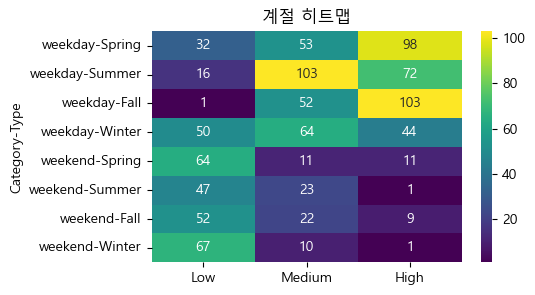

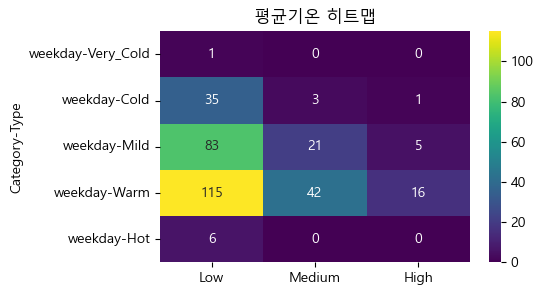

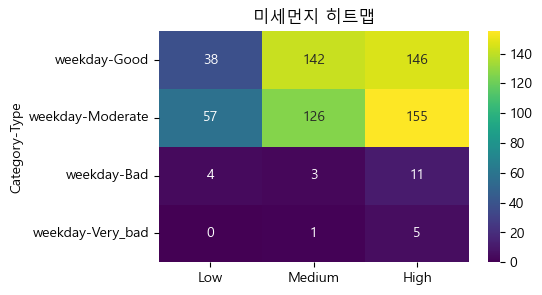

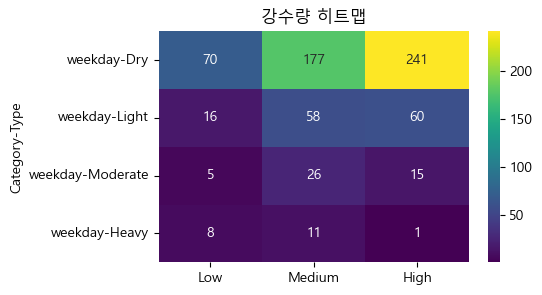

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 주어진 데이터를 Pandas DataFrame으로 변환
data = {
    '계절': {
        'weekday': {
            'Spring': {'Low': 32, 'Medium': 53, 'High': 98},
            'Summer': {'Low': 16, 'Medium': 103, 'High': 72},
            'Fall': {'Low': 1, 'Medium': 52, 'High': 103},
            'Winter': {'Low': 50, 'Medium': 64, 'High': 44}
        },
        'weekend': {
            'Spring': {'Low': 64, 'Medium': 11, 'High': 11},
            'Summer': {'Low': 47, 'Medium': 23, 'High': 1},
            'Fall': {'Low': 52, 'Medium': 22, 'High': 9},
            'Winter': {'Low': 67, 'Medium': 10, 'High': 1}
        }
    },
    '평균기온': {
        'weekday': {
            'Very_Cold': {'Low': 1, 'Medium': 0, 'High': 0},
            'Cold': {'Low': 35, 'Medium': 3, 'High': 1},
            'Mild': {'Low': 83, 'Medium': 21, 'High': 5},
            'Warm': {'Low': 115, 'Medium': 42, 'High': 16},
            'Hot': {'Low': 6, 'Medium': 0, 'High': 0}
        }
    },
    '미세먼지': {
        'weekday': {
            'Good': {'Low': 38, 'Medium': 142, 'High': 146},
            'Moderate': {'Low': 57, 'Medium': 126, 'High': 155},
            'Bad': {'Low': 4, 'Medium': 3, 'High': 11},
            'Very_bad': {'Low': 0, 'Medium': 1, 'High': 5}
        }
    },
    '강수량': {
        'weekday': {
            'Dry': {'Low': 70, 'Medium': 177, 'High': 241},
            'Light': {'Low': 16, 'Medium': 58, 'High': 60},
            'Moderate': {'Low': 5, 'Medium': 26, 'High': 15},
            'Heavy': {'Low': 8, 'Medium': 11, 'High': 1}
        }
    }
}

# 각 교차표를 DataFrame으로 변환하고 히트맵 생성
def plot_heatmap(category_data, title):
    # MultiIndex를 이용해 DataFrame 변환
    df = pd.DataFrame.from_dict({(i,j): category_data[i][j] 
                                 for i in category_data.keys() 
                                 for j in category_data[i].keys()}).T
    df.index.names = ['Category', 'Type']
    
    # 히트맵 생성
    plt.figure(figsize=(5, 3))
    sns.heatmap(df, annot=True, cmap="viridis", cbar=True, fmt="d")
    plt.title(title)
    plt.show()

# 각 교차표에 대해 히트맵 생성
plot_heatmap(data['계절'], '계절 히트맵')
plot_heatmap(data['평균기온'], '평균기온 히트맵')
plot_heatmap(data['미세먼지'], '미세먼지 히트맵')
plot_heatmap(data['강수량'], '강수량 히트맵')


3-3-6. 카이제곱 검정을 위한 통근자 함수생성

In [63]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임에서 승객 데이터를 범주화하고 교차표 생성
def create_contingency_tables(df, category_col):
    """
    데이터프레임에서 승객 데이터를 범주화하고 교차표 생성
    
    Args:
        df: 분석할 데이터프레임
        category_col: 분석할 범주형 컬럼명 (예: 'season' 또는 'p_grade')
    """
    # 비통근 승객 수 합계 계산 및 3분위수로 범주화
    df['total_other'] = df['bus_commute_passenger'] + df['train_commute_passenger']
    df['other_category'] = pd.qcut(df['total_other'], q=3, labels=['Low', 'Medium', 'High'])
    
    # 평일/주말 데이터 분리 (day_type이 0이면 평일, 1이면 주말/공휴일)
    weekday_data = df[df['day_type'] == "Weekday"]
    weekend_data = df[df['day_type'] == "Weekend"]
    
    # 교차표 생성
    weekday_contingency = pd.crosstab(weekday_data[category_col], weekday_data['other_category'])
    weekend_contingency = pd.crosstab(weekend_data[category_col], weekend_data['other_category'])
    
    return weekday_contingency, weekend_contingency

# 카이제곱 검정 및 결과 출력 함수
def perform_chi2_test(weekday_contingency, weekend_contingency, category_name):
    """
    교차표에 대해 카이제곱 검정을 수행하고 결과 출력
    
    Args:
        weekday_contingency: 평일 교차표
        weekend_contingency: 주말 교차표
        category_name: 분석 중인 범주의 이름 (예: '계절' 또는 '강수량')
    """
    # 평일 분석
    weekday_chi2, weekday_p, weekday_dof, weekday_expected = chi2_contingency(weekday_contingency)
    
    # 주말 분석
    weekend_chi2, weekend_p, weekend_dof, weekend_expected = chi2_contingency(weekend_contingency)
    
    print(f"=== 평일 {category_name} 분석 ===")
    print("\n교차표:")
    print(weekday_contingency)
    print(f"\n카이제곱 통계량: {weekday_chi2:.2f}")
    print(f"p-value: {weekday_p:.4f}")
    
    print(f"\n=== 주말/공휴일 {category_name} 분석 ===")
    print("\n교차표:")
    print(weekend_contingency)
    print(f"\n카이제곱 통계량: {weekend_chi2:.2f}")
    print(f"p-value: {weekend_p:.4f}")

3-3-7. 통근 승객과 계절

In [64]:
# 통근 승객과 계절 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'season')
perform_chi2_test(weekday_contingency, weekend_contingency, '계절')

=== 평일 계절 분석 ===

교차표:
other_category  Low  Medium  High
season                           
Spring            1      52   130
Summer            5     109    77
Fall              0      31   125
Winter            7     144     7

카이제곱 통계량: 228.93
p-value: 0.0000

=== 주말/공휴일 계절 분석 ===

교차표:
other_category  Low  Medium
season                     
Spring           86       0
Summer           79       2
Fall             83       0
Winter           78       0

카이제곱 통계량: 6.14
p-value: 0.1052


** 통근 승객과 계절의 경우 평일 p-value는 0.0000으로 현저히 낮으므로 유의미하다고 판단된다

3-3-8. 통근 승객과 평균기온

In [65]:
# 통근 승객과 평균기온 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'at_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '평균기온')


=== 평일 평균기온 분석 ===

교차표:
other_category  Low  Medium  High
at_grade                         
Very_Cold         0       5     0
Cold              4      65     7
Mild              3     123   104
Warm              6     134   228
Hot               0       9     0

카이제곱 통계량: 90.92
p-value: 0.0000

=== 주말/공휴일 평균기온 분석 ===

교차표:
other_category  Low  Medium
at_grade                   
Very_Cold         1       0
Cold             39       0
Mild            109       0
Warm            171       2
Hot               6       0

카이제곱 통계량: 1.80
p-value: 0.7720


** 통근 승객과 평균기온의 경우 평일 p-value는 0.0000으로 현저히 낮으므로 유의미하다고 판단된다

3-3-9. 통근 승객과 미세먼지

In [66]:
# 통근 승객과 미세먼지 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'fd_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '미세먼지')

=== 평일 미세먼지 분석 ===

교차표:
other_category  Low  Medium  High
fd_grade                         
Good              6     164   156
Normal            7     164   167
Bad               0       7    11
Very_bad          0       1     5

카이제곱 통계량: 4.36
p-value: 0.6276

=== 주말/공휴일 미세먼지 분석 ===

교차표:
other_category  Low  Medium
fd_grade                   
Good            160       1
Normal          152       1
Bad              13       0
Very_bad          1       0

카이제곱 통계량: 0.09
p-value: 0.9929


3-3-10. 통근 승객과 강수량

In [67]:
# 통근 승객과 강수량 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'p_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '강수량')

=== 평일 강수량 분석 ===

교차표:
other_category  Low  Medium  High
p_grade                          
Dry              11     227   250
Light             1      68    65
Moderate          0      24    22
Heavy             1      17     2

카이제곱 통계량: 15.94
p-value: 0.0141

=== 주말/공휴일 강수량 분석 ===

교차표:
other_category  Low  Medium
p_grade                    
Dry             224       0
Light            65       1
Moderate         35       1
Heavy             2       0

카이제곱 통계량: 5.07
p-value: 0.1666


** 통근 승객과 강수량의 경우 평일 p-value는 0.0141로 낮으므로 유의미하다고 판단된다

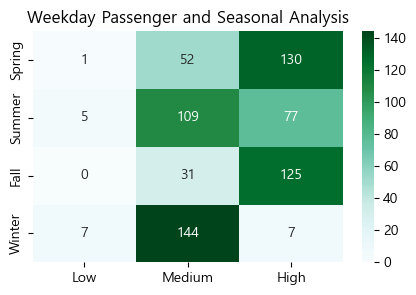

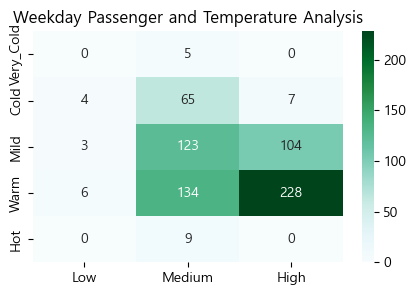

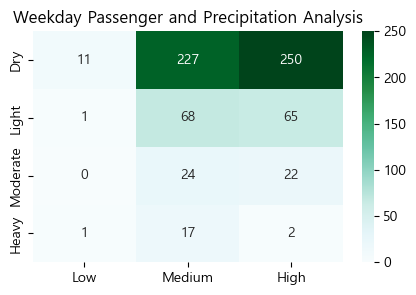

In [118]:
# 평일 계절 분석 교차표 데이터 정의
weekday_season_data = {
    'Low': [1, 5, 0, 7],
    'Medium': [52, 109, 31, 144],
    'High': [130, 77, 125, 7]
}
# 평일 평균기온 분석 교차표 데이터 정의
weekday_temp_data = {
    'Low': [0, 4, 3, 6, 0],
    'Medium': [5, 65, 123, 134, 9],
    'High': [0, 7, 104, 228, 0]
}
# 평일 강수량 분석 교차표 데이터 정의
weekday_precip_data = {
    'Low': [11, 1, 0, 1],
    'Medium': [227, 68, 24, 17],
    'High': [250, 65, 22, 2]
}

# 각 교차표를 데이터프레임으로 변환
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
temps = ['Very_Cold', 'Cold', 'Mild', 'Warm', 'Hot']
precips = ['Dry', 'Light', 'Moderate', 'Heavy']

df_weekday_season = pd.DataFrame(weekday_season_data, index=seasons)
df_weekday_temp = pd.DataFrame(weekday_temp_data, index=temps)
df_weekday_precip = pd.DataFrame(weekday_precip_data, index=precips)

# 히트맵 생성 함수
def plot_heatmap(data, title):
    plt.figure(figsize=(5, 3))
    sns.heatmap(data, annot=True, fmt="d", cmap="BuGn", cbar=True)
    plt.title(title)
    plt.show()

# 히트맵 생성
plot_heatmap(df_weekday_season, "Weekday Passenger and Seasonal Analysis")
plot_heatmap(df_weekday_temp, "Weekday Passenger and Temperature Analysis")
plot_heatmap(df_weekday_precip, "Weekday Passenger and Precipitation Analysis")


3-3-11. 카이제곱 검정을 위한 전체 승객 함수생성

In [68]:
import pandas as pd
from scipy.stats import chi2_contingency

# 데이터프레임에서 승객 데이터를 범주화하고 교차표 생성
def create_contingency_tables(df, category_col):
    """
    데이터프레임에서 승객 데이터를 범주화하고 교차표 생성
    
    Args:
        df: 분석할 데이터프레임
        category_col: 분석할 범주형 컬럼명 (예: 'season' 또는 'p_grade')
    """
    # 비통근 승객 수 합계 계산 및 3분위수로 범주화
    df['total_other'] = df['bus_total_passenger'] + df['train_total_passenger']
    df['other_category'] = pd.qcut(df['total_other'], q=3, labels=['Low', 'Medium', 'High'])
    
    # 평일/주말 데이터 분리 (day_type이 0이면 평일, 1이면 주말/공휴일)
    weekday_data = df[df['day_type'] == "Weekday"]
    weekend_data = df[df['day_type'] == "Weekend"]
    
    # 교차표 생성
    weekday_contingency = pd.crosstab(weekday_data[category_col], weekday_data['other_category'])
    weekend_contingency = pd.crosstab(weekend_data[category_col], weekend_data['other_category'])
    
    return weekday_contingency, weekend_contingency

# 카이제곱 검정 및 결과 출력 함수
def perform_chi2_test(weekday_contingency, weekend_contingency, category_name):
    """
    교차표에 대해 카이제곱 검정을 수행하고 결과 출력
    
    Args:
        weekday_contingency: 평일 교차표
        weekend_contingency: 주말 교차표
        category_name: 분석 중인 범주의 이름 (예: '계절' 또는 '강수량')
    """
    # 평일 분석
    weekday_chi2, weekday_p, weekday_dof, weekday_expected = chi2_contingency(weekday_contingency)
    
    # 주말 분석
    weekend_chi2, weekend_p, weekend_dof, weekend_expected = chi2_contingency(weekend_contingency)
    
    print(f"=== 평일 {category_name} 분석 ===")
    print("\n교차표:")
    print(weekday_contingency)
    print(f"\n카이제곱 통계량: {weekday_chi2:.2f}")
    print(f"p-value: {weekday_p:.4f}")
    
    print(f"\n=== 주말/공휴일 {category_name} 분석 ===")
    print("\n교차표:")
    print(weekend_contingency)
    print(f"\n카이제곱 통계량: {weekend_chi2:.2f}")
    print(f"p-value: {weekend_p:.4f}")

3-3-12. 전체 승객과 계절

In [69]:
# 통근 승객과 계절 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'season')
perform_chi2_test(weekday_contingency, weekend_contingency, '계절')

=== 평일 계절 분석 ===

교차표:
other_category  Low  Medium  High
season                           
Spring            6      63   114
Summer            4     109    78
Fall              0      35   121
Winter            8     124    26

카이제곱 통계량: 139.11
p-value: 0.0000

=== 주말/공휴일 계절 분석 ===

교차표:
other_category  Low  Medium
season                     
Spring           84       2
Summer           79       2
Fall             80       3
Winter           78       0

카이제곱 통계량: 2.63
p-value: 0.4522


** 전체 승객과 계절의 경우 평일 p-value는 0.0000으로 현저히 낮으므로 유의미하다고 판단된다

3-3-13. 전체 승객과 평균기온

In [70]:
# 통근 승객과 평균기온 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'at_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '평균기온')

=== 평일 평균기온 분석 ===

교차표:
other_category  Low  Medium  High
at_grade                         
Very_Cold         0       4     1
Cold              7      59    10
Mild              6     120   104
Warm              5     140   223
Hot               0       8     1

카이제곱 통계량: 75.69
p-value: 0.0000

=== 주말/공휴일 평균기온 분석 ===

교차표:
other_category  Low  Medium
at_grade                   
Very_Cold         1       0
Cold             39       0
Mild            108       1
Warm            167       6
Hot               6       0

카이제곱 통계량: 3.25
p-value: 0.5169


** 전체 승객과 평균기온의 경우 평일 p-value는 0.0000으로 현저히 낮으므로 유의미하다고 판단된다

3-3-14. 전체 승객과 미세먼지

In [71]:
# 통근 승객과 미세먼지 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'fd_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '미세먼지')

=== 평일 미세먼지 분석 ===

교차표:
other_category  Low  Medium  High
fd_grade                         
Good              7     161   158
Normal           11     162   165
Bad               0       7    11
Very_bad          0       1     5

카이제곱 통계량: 5.07
p-value: 0.5344

=== 주말/공휴일 미세먼지 분석 ===

교차표:
other_category  Low  Medium
fd_grade                   
Good            157       4
Normal          150       3
Bad              13       0
Very_bad          1       0

카이제곱 통계량: 0.42
p-value: 0.9357


3-3-15. 전체 승객과 강수량

In [72]:
# 통근 승객과 강수량 카이제곱 검정
weekday_contingency, weekend_contingency = create_contingency_tables(merged_df, 'p_grade')
perform_chi2_test(weekday_contingency, weekend_contingency, '강수량')

=== 평일 강수량 분석 ===

교차표:
other_category  Low  Medium  High
p_grade                          
Dry              14     222   252
Light             3      62    69
Moderate          0      29    17
Heavy             1      18     1

카이제곱 통계량: 22.11
p-value: 0.0012

=== 주말/공휴일 강수량 분석 ===

교차표:
other_category  Low  Medium
p_grade                    
Dry             219       5
Light            65       1
Moderate         35       1
Heavy             2       0

카이제곱 통계량: 0.25
p-value: 0.9698


** 전체 승객과 강수량의 경우 평일 p-value는 0.0012로 현저히 낮으므로 유의미하다고 판단된다

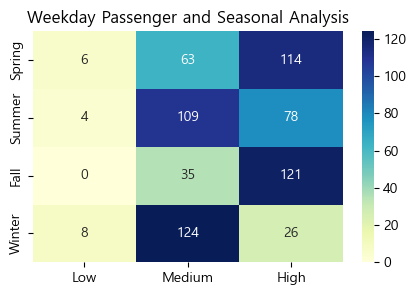

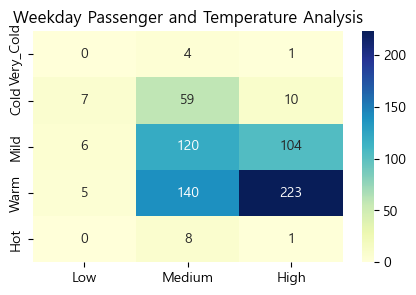

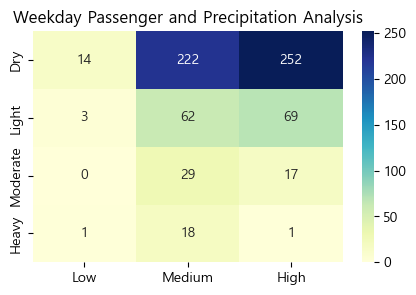

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 새로운 평일 계절 분석 교차표 데이터 정의
new_weekday_season_data = {
    'Low': [6, 4, 0, 8],
    'Medium': [63, 109, 35, 124],
    'High': [114, 78, 121, 26]
}
# 새로운 평일 평균기온 분석 교차표 데이터 정의
new_weekday_temp_data = {
    'Low': [0, 7, 6, 5, 0],
    'Medium': [4, 59, 120, 140, 8],
    'High': [1, 10, 104, 223, 1]
}
# 새로운 평일 강수량 분석 교차표 데이터 정의
new_weekday_precip_data = {
    'Low': [14, 3, 0, 1],
    'Medium': [222, 62, 29, 18],
    'High': [252, 69, 17, 1]
}

# 각 교차표를 데이터프레임으로 변환
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
temps = ['Very_Cold', 'Cold', 'Mild', 'Warm', 'Hot']
precips = ['Dry', 'Light', 'Moderate', 'Heavy']

new_df_weekday_season = pd.DataFrame(new_weekday_season_data, index=seasons)
new_df_weekday_temp = pd.DataFrame(new_weekday_temp_data, index=temps)
new_df_weekday_precip = pd.DataFrame(new_weekday_precip_data, index=precips)

# 히트맵 생성 함수
def plot_heatmap(data, title):
    plt.figure(figsize=(5, 3))
    sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.show()

# 히트맵 생성
plot_heatmap(new_df_weekday_season, "Weekday Passenger and Seasonal Analysis")
plot_heatmap(new_df_weekday_temp, "Weekday Passenger and Temperature Analysis")
plot_heatmap(new_df_weekday_precip, "Weekday Passenger and Precipitation Analysis")


In [73]:
merged_df.to_csv("data/all_scaled_merged_data.csv")